In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.sql import functions as f
from pyspark.sql import SparkSession, functions as F

In [2]:
#Building session now
spark = SparkSession.builder.appName('deep_learning_with_spark').getOrCreate()
#Reading the files now
data = spark.read.csv('/home/jovyan/work/avocado.csv', header=True, inferSchema=True)
trendsData = spark.read.csv('/home/jovyan/work/multiTimeline.csv', header=True, inferSchema=True)

In [3]:
#Preprocess unused data out of the dataframe and name Total Volume more appropriately
data = data.withColumnRenamed("Total Volume", "totalVolume").select("Date", "AveragePrice", "totalVolume", "type", "year", "region").orderBy("Date")
print("Avocado data schema: \n", data.schema)
print("\nGoogle Trends data schema: \n", trendsData.schema)

Avocado data schema: 
 StructType(List(StructField(Date,TimestampType,true),StructField(AveragePrice,DoubleType,true),StructField(totalVolume,DoubleType,true),StructField(type,StringType,true),StructField(year,IntegerType,true),StructField(region,StringType,true)))

Google Trends data schema: 
 StructType(List(StructField(Viikko,TimestampType,true),StructField(avocado,IntegerType,true)))


In [4]:
#Make list of year changes for nice plotting
yearsOnly = data.select("year").filter(data.region == "Boston").filter(data.type == "organic").collect()
yearsOnly = [v['year'] for v in yearsOnly]
oldYear = 0
yearsForX = []

for year in yearsOnly:
    if year == oldYear:
        yearsForX.append("")
    else:
        oldYear = year
        yearsForX.append(oldYear)

In [5]:
averagePricesAndCitiesConvent = []
averagePricesAndCitiesOrgan = []

totalVolumesAndCitiesConvent = []
totalVolumesAndCitiesOrgan = []

In [6]:
def pricesForCity(city):
    averagePriceAndCityConvent = [city]
    averagePriceAndCityOrgan = [city]
    dataFilteredConvent = data.filter(data.region == city).filter(data.type == "conventional").orderBy("Date")
    dataFilteredOrgan = data.filter(data.region == city).filter(data.type == "organic").orderBy("Date")
    
    dataPricesOnlyConvent = dataFilteredConvent.select("AveragePrice", "year")
    dataPricesOnlyOrgan = dataFilteredOrgan.select("AveragePrice", "year")

    dff = dataPricesOnlyConvent.toPandas()
    dff1 = dataPricesOnlyOrgan.toPandas()
    
    #Plot for average price
    plt.style.use('seaborn-white')
    plt_1 = plt.figure(figsize=(12,6))
    params = {'legend.fontsize': 'large','figure.figsize': (80, 40),'axes.labelsize': 'x-large','axes.titlesize':'x-large','xtick.labelsize':'large','ytick.labelsize':'large'}
    
    plt.plot(dff.AveragePrice)
    plt.plot(dff1.AveragePrice)
    plt.xticks(range(len(yearsForX)), yearsForX)
    plt.ylabel("$")
    plt.xlabel(city)
    plt.legend(["Conventional", "Organic"])
    plt.show()
    plt.close()
    
    priceAver = 0
    priceAverOrganic = 0
    for i in range(165):
        priceAver = priceAver + dff.AveragePrice[i]
        priceAverOrganic = priceAverOrganic + dff1.AveragePrice[i]

    averagePriceAndCityConvent.append(priceAver/165)
    averagePriceAndCityOrgan.append(priceAverOrganic/165)
    
    averagePricesAndCitiesConvent.append(averagePriceAndCityConvent)
    averagePricesAndCitiesOrgan.append(averagePriceAndCityOrgan)
    
    print(city, "average price conventional: ", str(round(priceAver/165, 2)))
    print(city, "average price organic: ", str(round(priceAverOrganic/165, 2)))

In [7]:
def volumesForCity(city):
    totalVolumeAndCityConvent = [city]
    totalVolumeAndCityOrgan = [city]
    
    dataFilteredConvent = data.filter(data.region == city).filter(data.type == "conventional").orderBy("Date")
    dataFilteredOrgan = data.filter(data.region == city).filter(data.type == "organic").orderBy("Date")
    
    dataVolumesOnlyConvent = dataFilteredConvent.select("totalVolume")
    dataVolumesOnlyOrgan = dataFilteredOrgan.select("totalVolume")

    dffVol = dataVolumesOnlyConvent.toPandas()
    dff1Vol = dataVolumesOnlyOrgan.toPandas()

    #Plot for total volume
    
    plt.style.use('seaborn-white')
    plt_1 = plt.figure(figsize=(12,6))
    params = {'legend.fontsize': 'large','figure.figsize': (80, 40),'axes.labelsize': 'x-large','axes.titlesize':'x-large','xtick.labelsize':'large','ytick.labelsize':'large'}
    
    plt.plot(dffVol)
    plt.plot(dff1Vol)
    plt.xlabel(city)
    plt.xticks(range(len(yearsForX)), yearsForX)
    plt.legend(["ConventionalVolume", "OrganicVolume"])
    plt.show()
    plt.close()
    
    totalVol = 0
    totalVolOrg = 0
    for i in range(165):
        totalVol = totalVol + dffVol.totalVolume[i]
        totalVolOrg = totalVolOrg + dff1Vol.totalVolume[i]
    
    totalVolumeAndCityConvent.append(int(totalVol))
    totalVolumeAndCityOrgan.append(int(totalVolOrg))
    
    totalVolumesAndCitiesConvent.append(totalVolumeAndCityConvent)
    totalVolumesAndCitiesOrgan.append(totalVolumeAndCityOrgan)
    
    print(city, "total volume conventional: ", int(totalVol))
    print(city, "total volume organic: ", int(totalVolOrg))

In [8]:
cities = data.select('region').distinct().orderBy("region").collect()
cities = [v['region'] for v in cities]

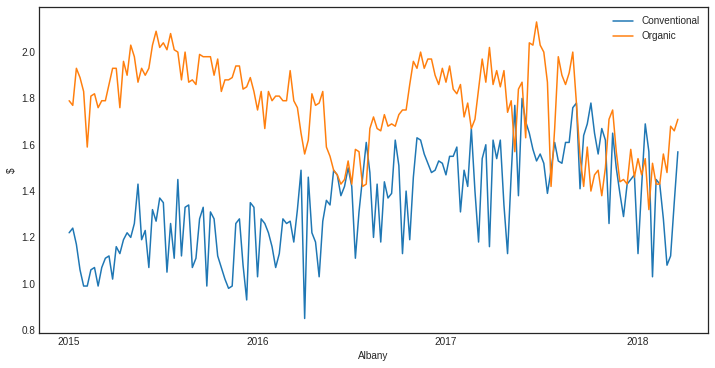

Albany average price conventional:  1.35
Albany average price organic:  1.78


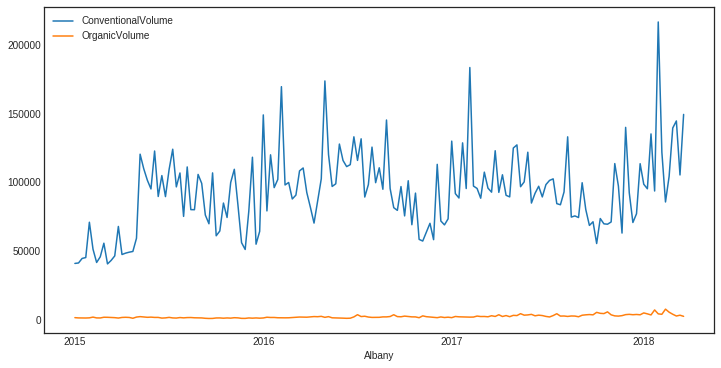

Albany total volume conventional:  15161740
Albany total volume organic:  355290


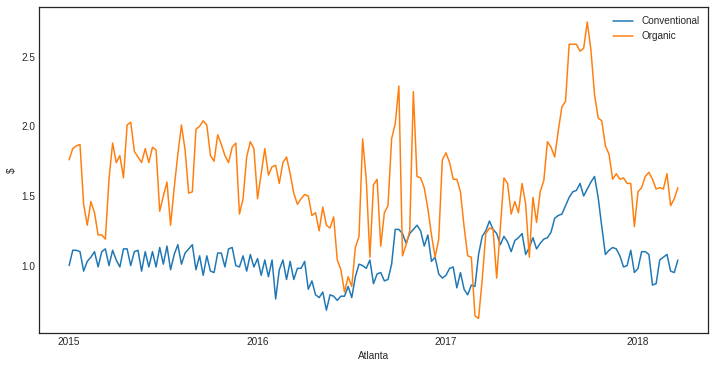

Atlanta average price conventional:  1.07
Atlanta average price organic:  1.61


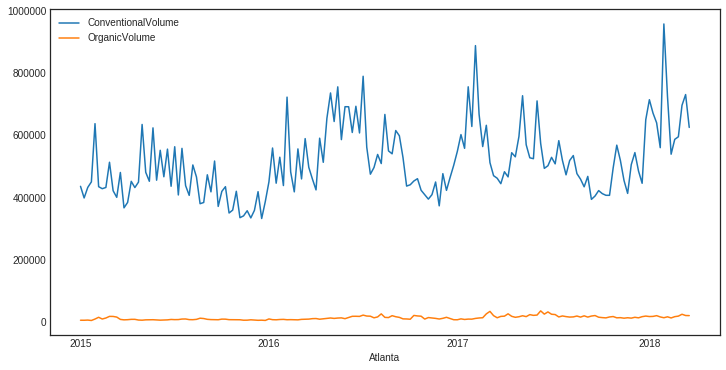

Atlanta total volume conventional:  84015923
Atlanta total volume organic:  1865870


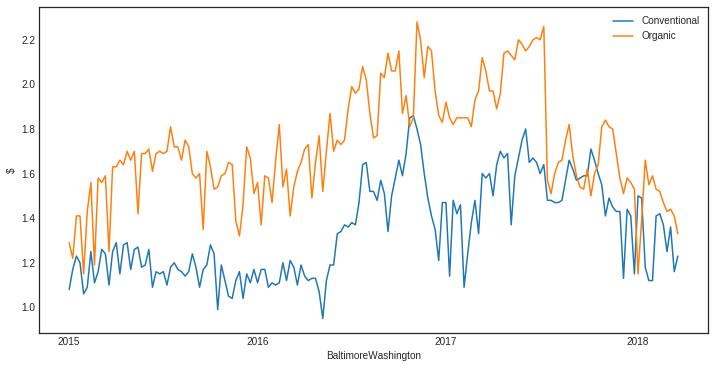

BaltimoreWashington average price conventional:  1.35
BaltimoreWashington average price organic:  1.73


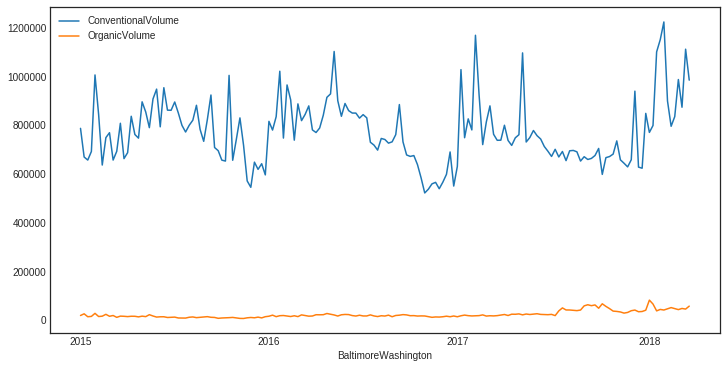

BaltimoreWashington total volume conventional:  126782940
BaltimoreWashington total volume organic:  3773886


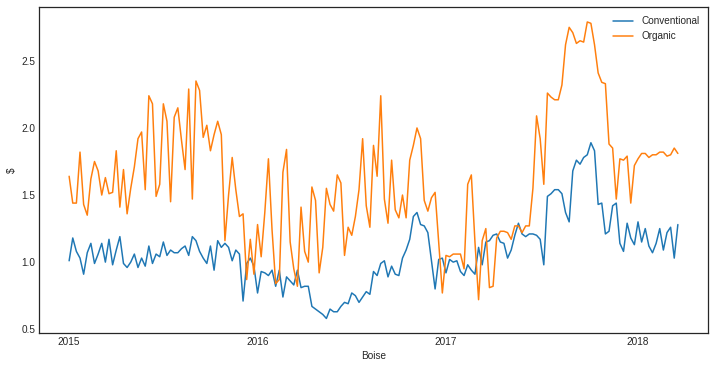

Boise average price conventional:  1.07
Boise average price organic:  1.62


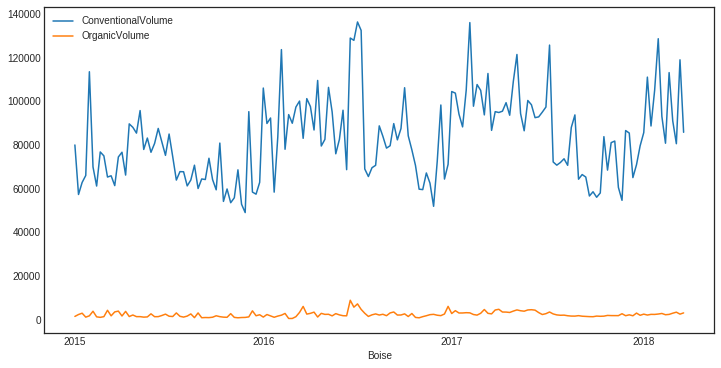

Boise total volume conventional:  13623973
Boise total volume organic:  400549


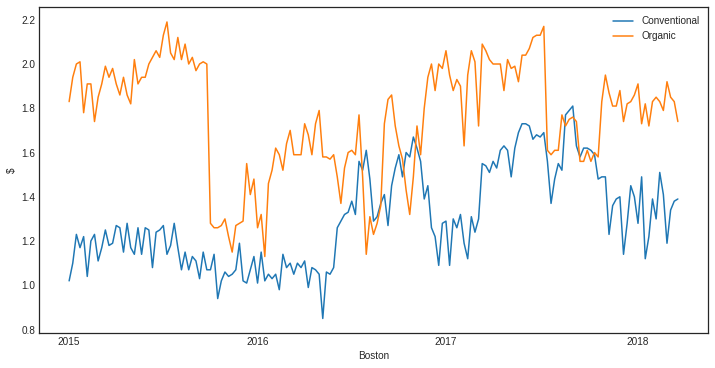

Boston average price conventional:  1.3
Boston average price organic:  1.76


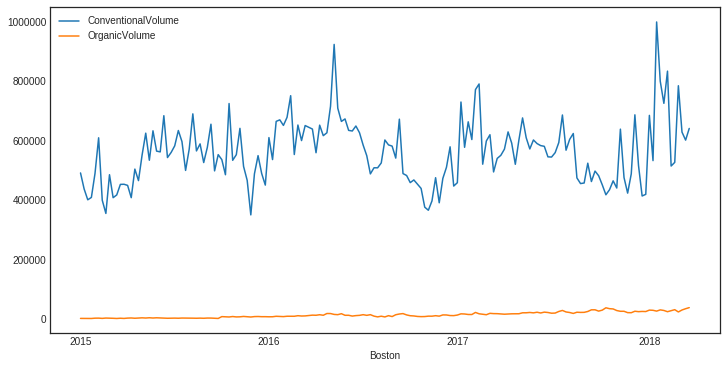

Boston total volume conventional:  92242518
Boston total volume organic:  2245928


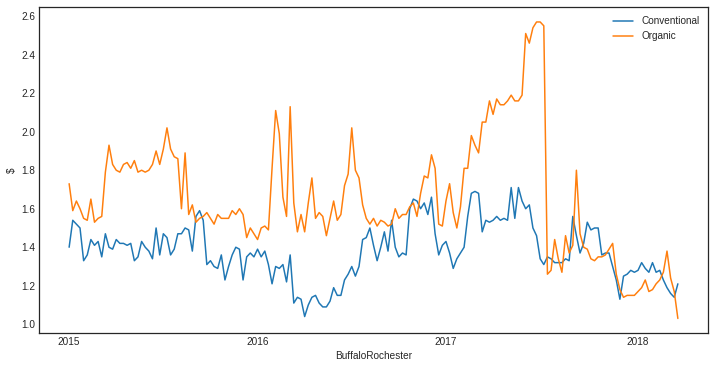

BuffaloRochester average price conventional:  1.39
BuffaloRochester average price organic:  1.66


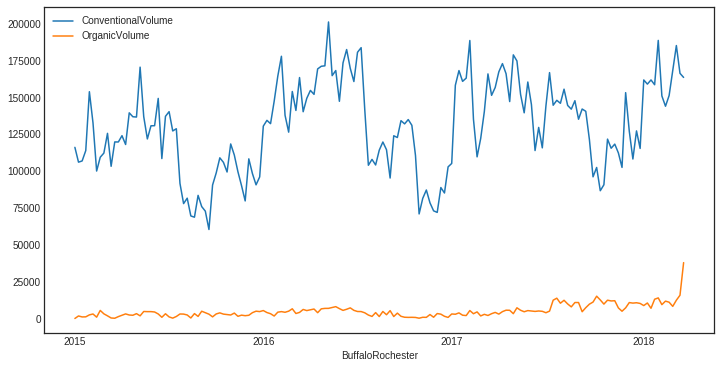

BuffaloRochester total volume conventional:  21355908
BuffaloRochester total volume organic:  847603


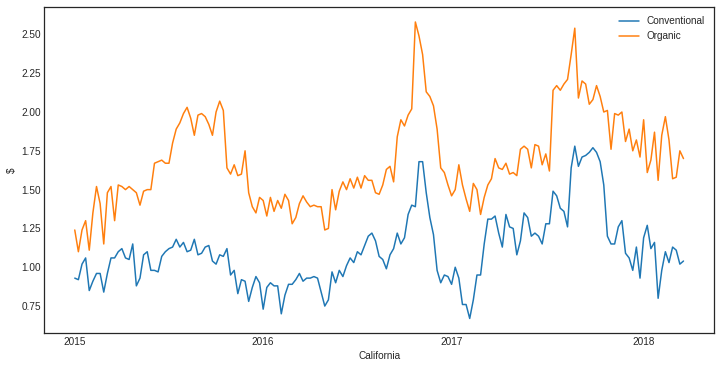

California average price conventional:  1.11
California average price organic:  1.69


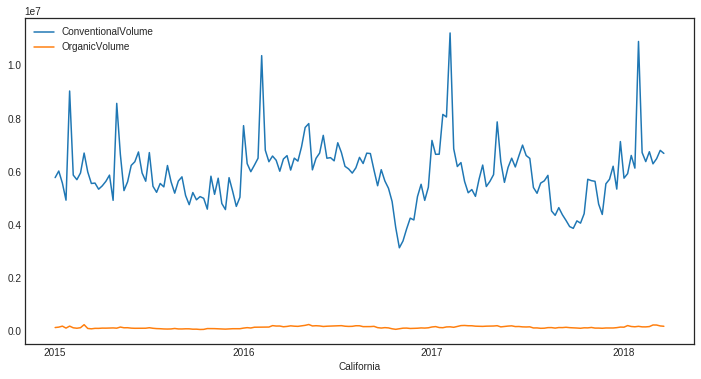

California total volume conventional:  977323612
California total volume organic:  24515805


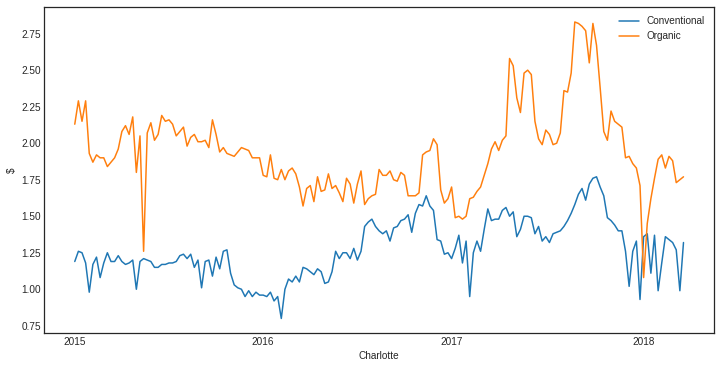

Charlotte average price conventional:  1.28
Charlotte average price organic:  1.94


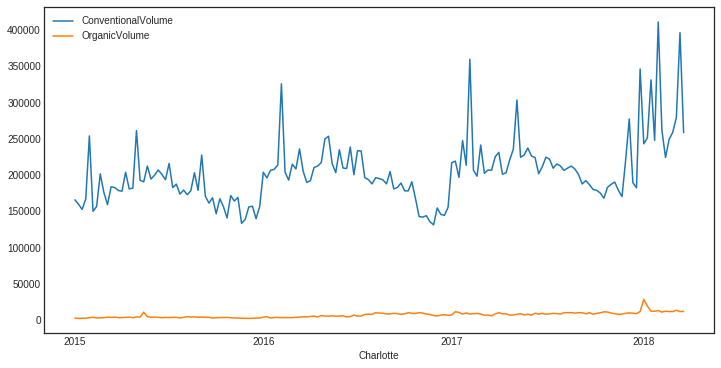

Charlotte total volume conventional:  33169279
Charlotte total volume organic:  1143072


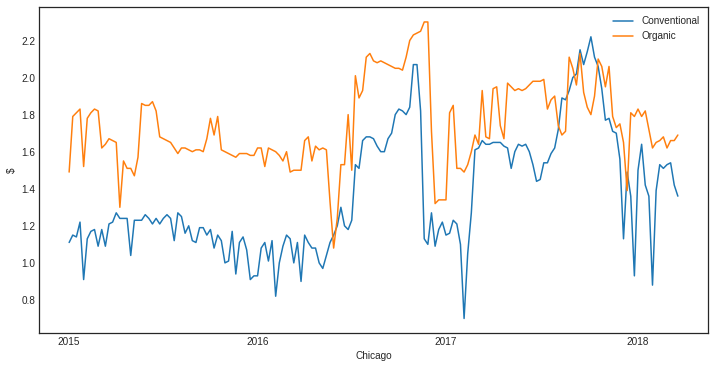

Chicago average price conventional:  1.37
Chicago average price organic:  1.75


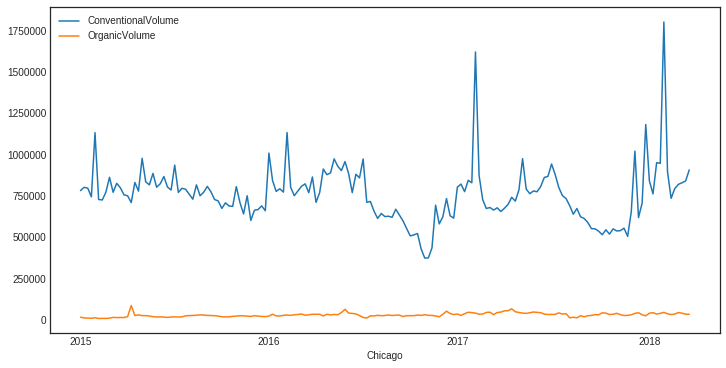

Chicago total volume conventional:  125008421
Chicago total volume organic:  5134766


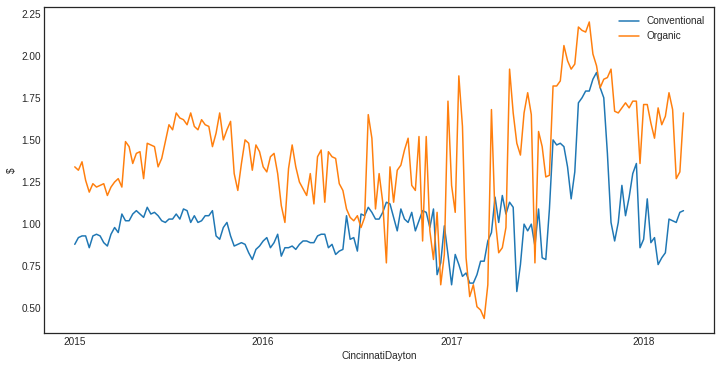

CincinnatiDayton average price conventional:  1.01
CincinnatiDayton average price organic:  1.4


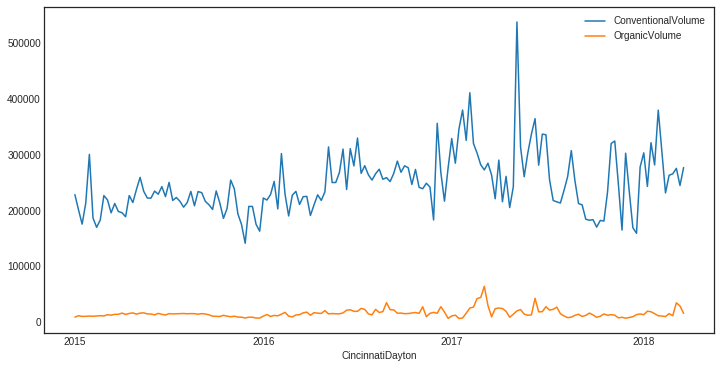

CincinnatiDayton total volume conventional:  40820020
CincinnatiDayton total volume organic:  2547917


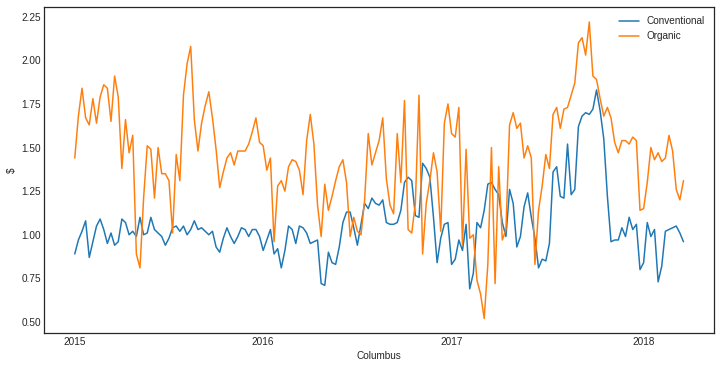

Columbus average price conventional:  1.07
Columbus average price organic:  1.44


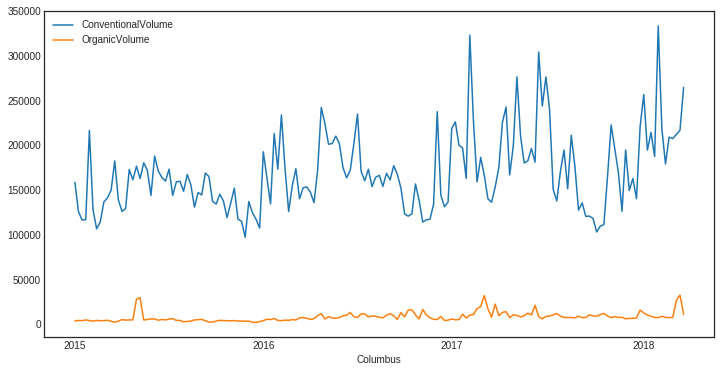

Columbus total volume conventional:  27704902
Columbus total volume organic:  1309146


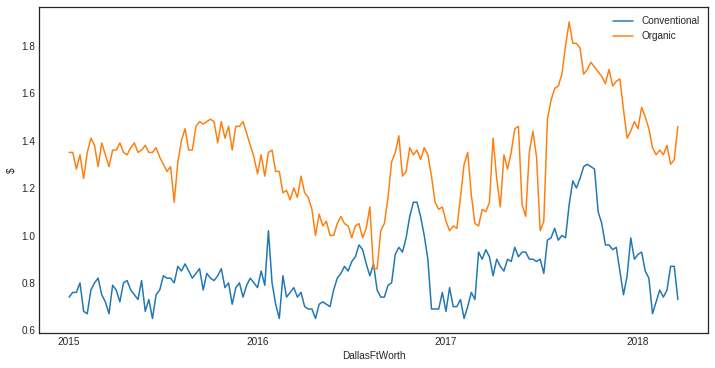

DallasFtWorth average price conventional:  0.85
DallasFtWorth average price organic:  1.32


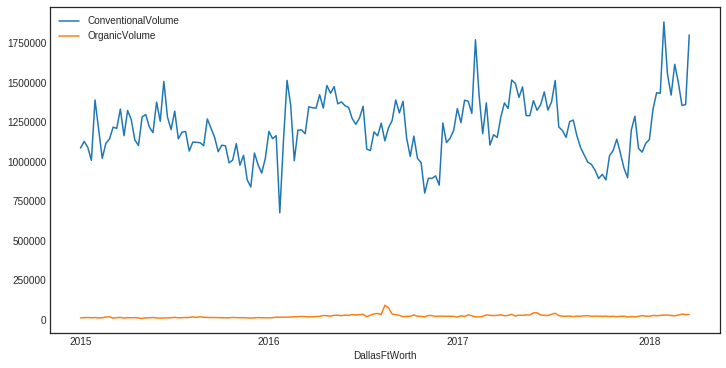

DallasFtWorth total volume conventional:  198887028
DallasFtWorth total volume organic:  3383980


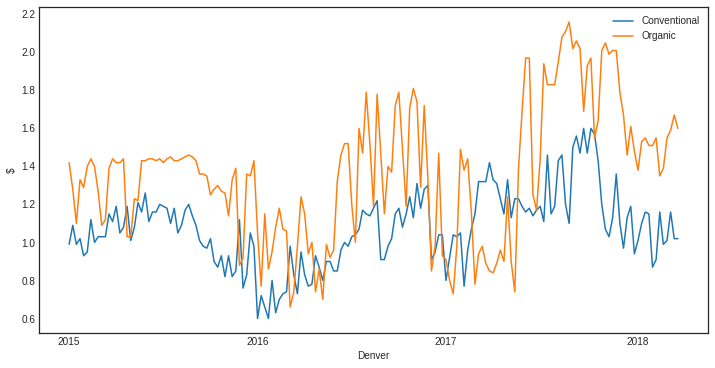

Denver average price conventional:  1.07
Denver average price organic:  1.36


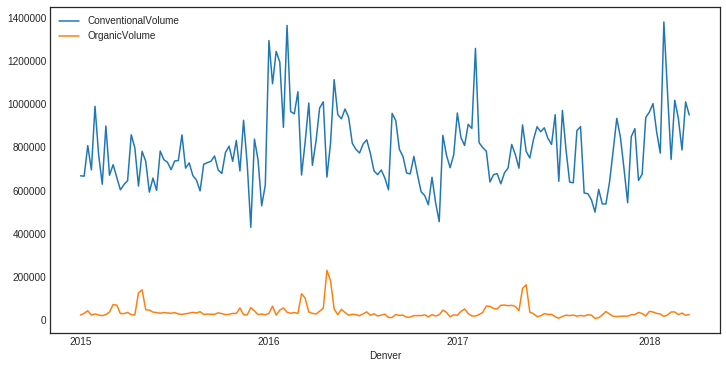

Denver total volume conventional:  129136392
Denver total volume organic:  5980069


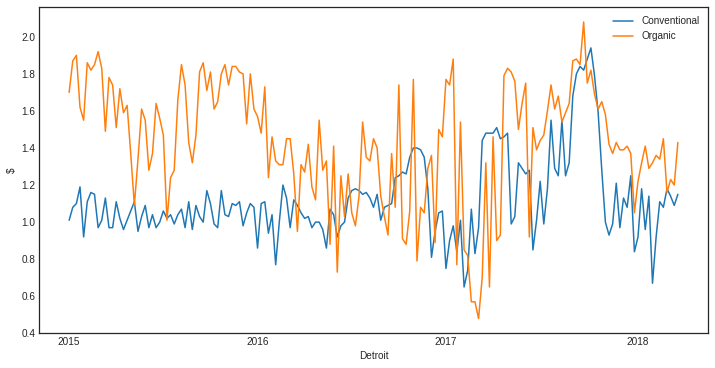

Detroit average price conventional:  1.12
Detroit average price organic:  1.43


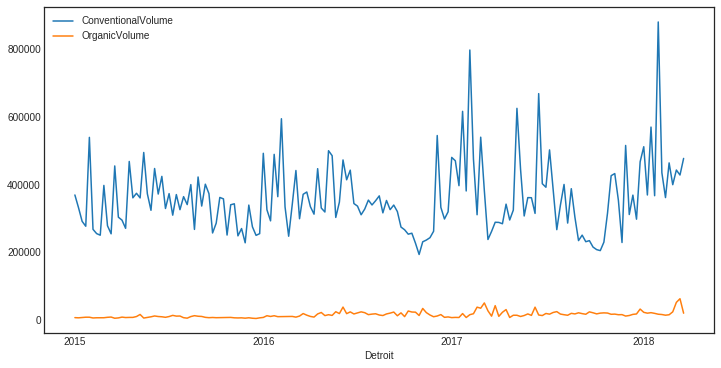

Detroit total volume conventional:  58997469
Detroit total volume organic:  2514457


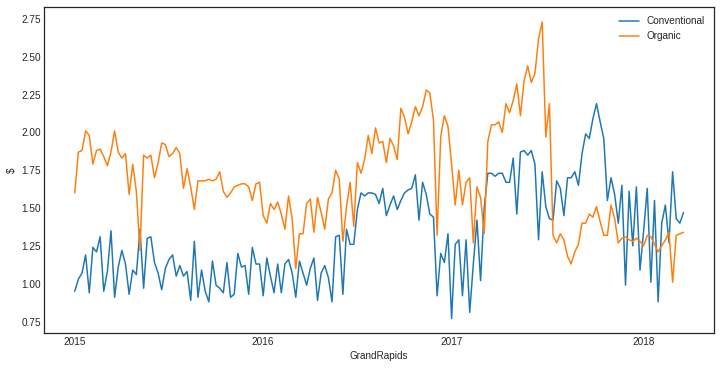

GrandRapids average price conventional:  1.32
GrandRapids average price organic:  1.7


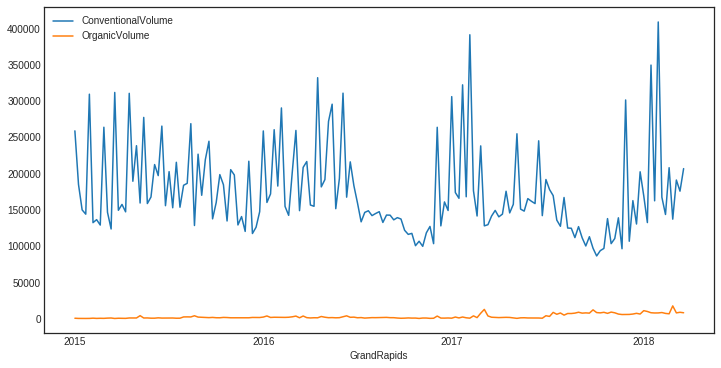

GrandRapids total volume conventional:  28926287
GrandRapids total volume organic:  529624


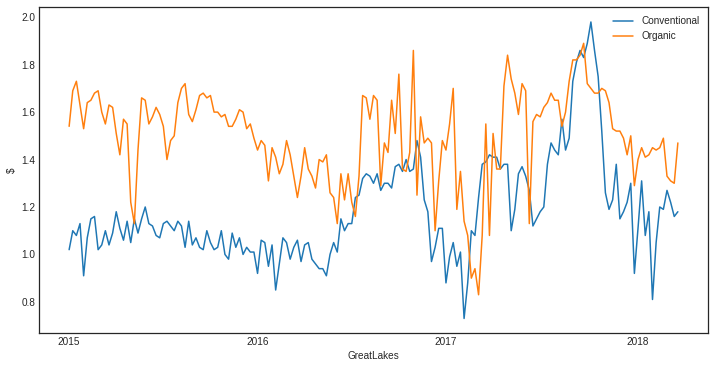

GreatLakes average price conventional:  1.18
GreatLakes average price organic:  1.5


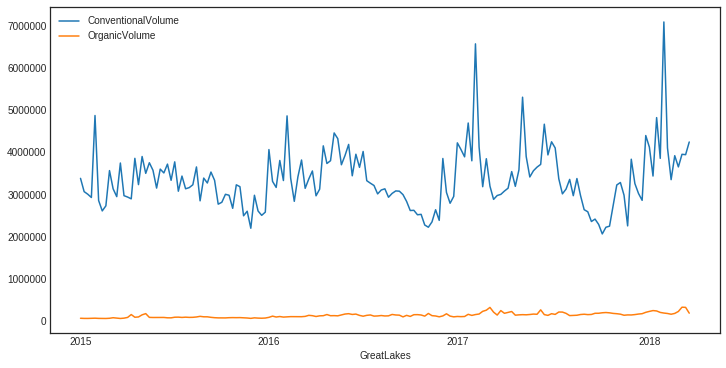

GreatLakes total volume conventional:  551768914
GreatLakes total volume organic:  21024751


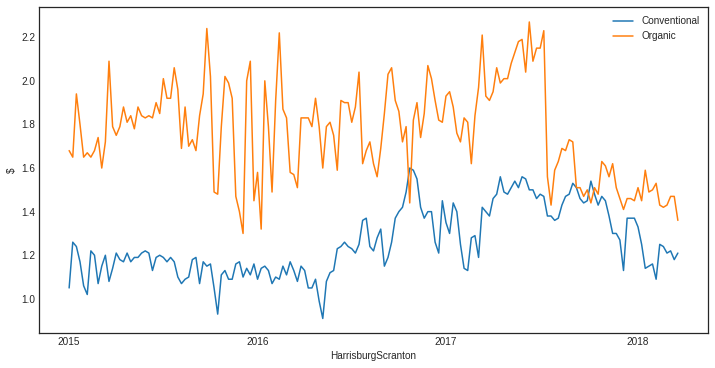

HarrisburgScranton average price conventional:  1.26
HarrisburgScranton average price organic:  1.78


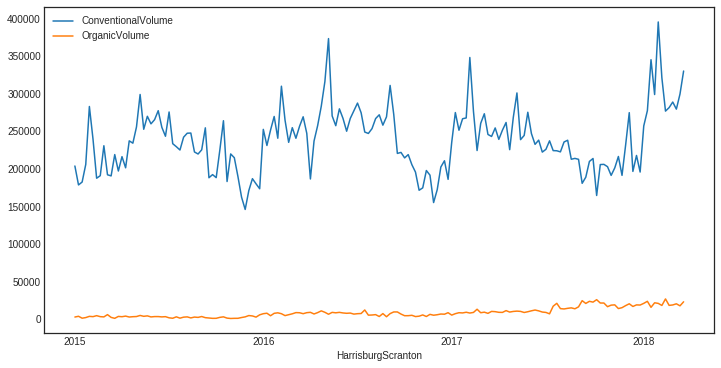

HarrisburgScranton total volume conventional:  39111189
HarrisburgScranton total volume organic:  1418362


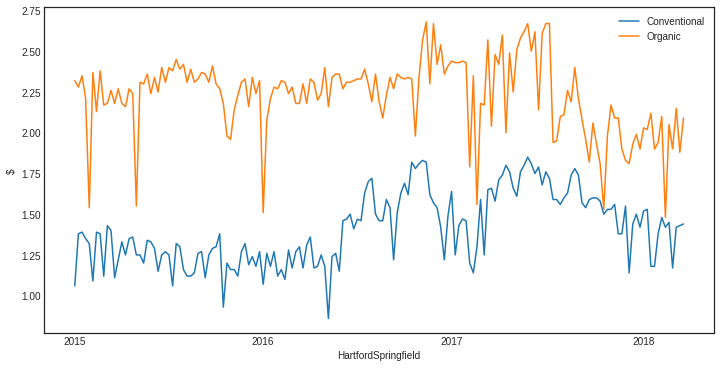

HartfordSpringfield average price conventional:  1.41
HartfordSpringfield average price organic:  2.23


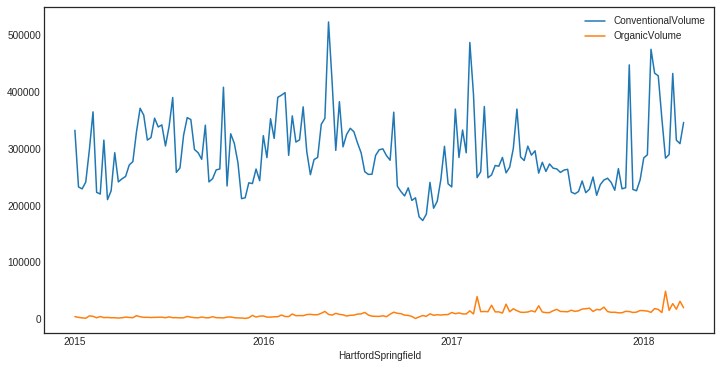

HartfordSpringfield total volume conventional:  47659601
HartfordSpringfield total volume organic:  1512003


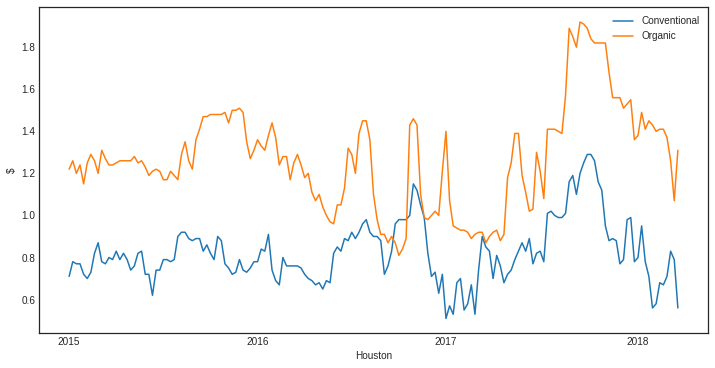

Houston average price conventional:  0.83
Houston average price organic:  1.27


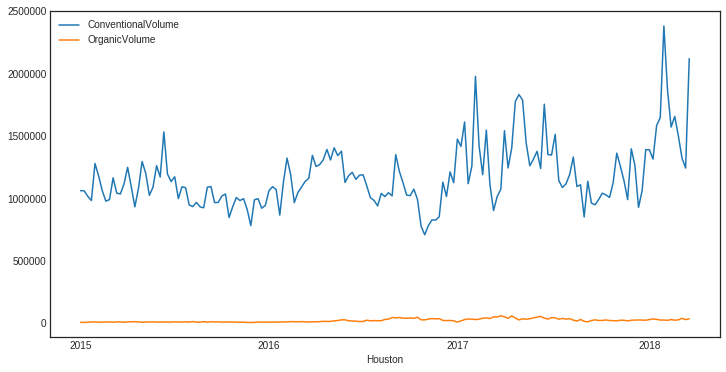

Houston total volume conventional:  193012316
Houston total volume organic:  3828168


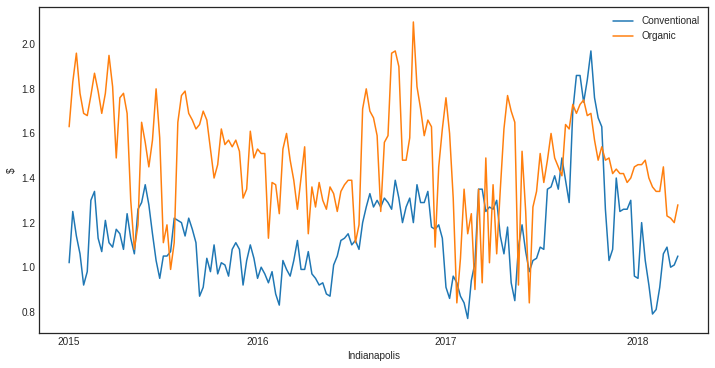

Indianapolis average price conventional:  1.15
Indianapolis average price organic:  1.49


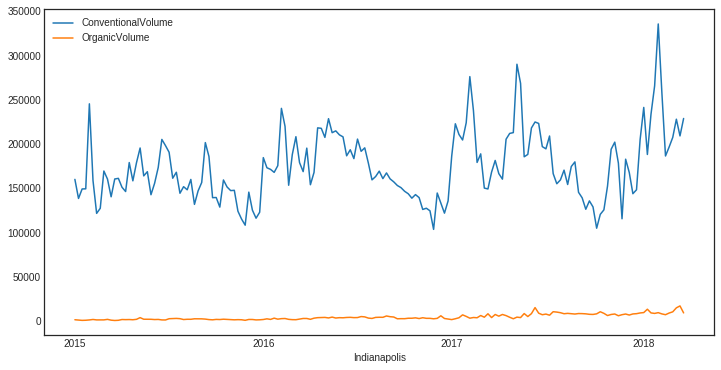

Indianapolis total volume conventional:  28579053
Indianapolis total volume organic:  758055


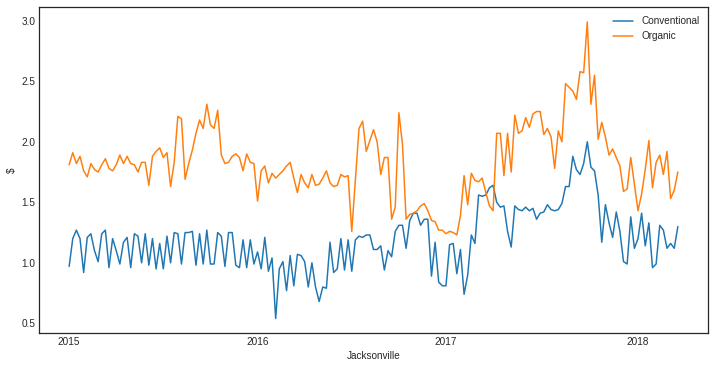

Jacksonville average price conventional:  1.19
Jacksonville average price organic:  1.83


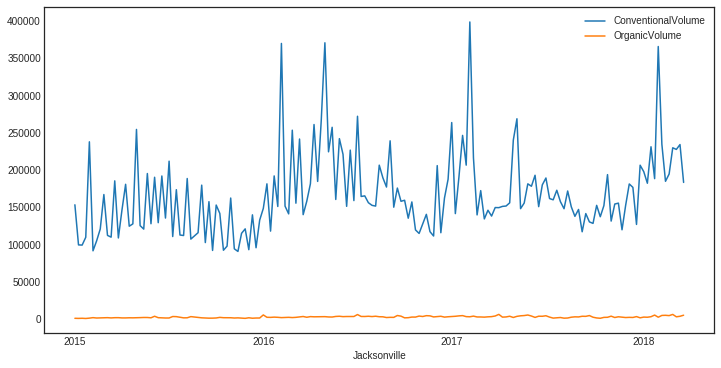

Jacksonville total volume conventional:  27390688
Jacksonville total volume organic:  504436


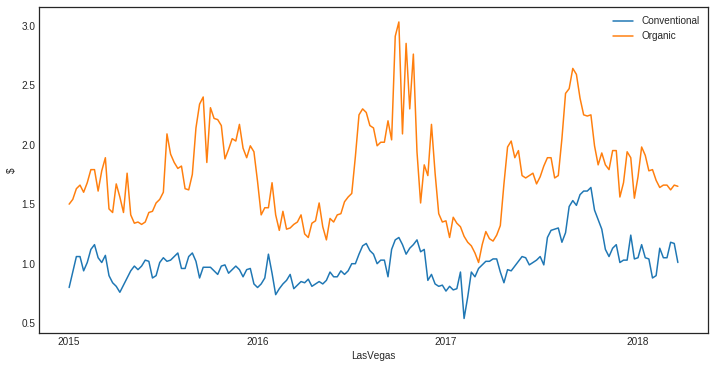

LasVegas average price conventional:  1.01
LasVegas average price organic:  1.75


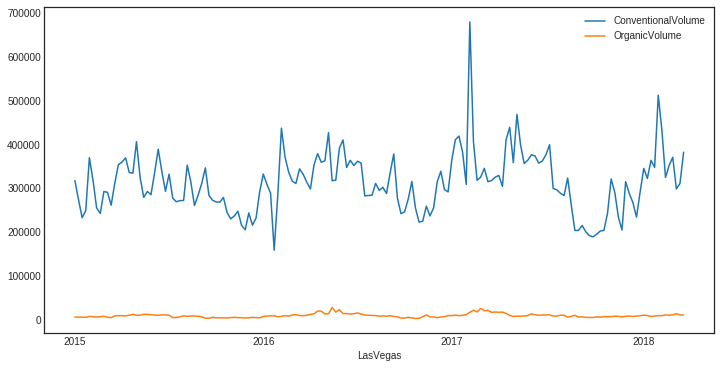

LasVegas total volume conventional:  51398907
LasVegas total volume organic:  1566410


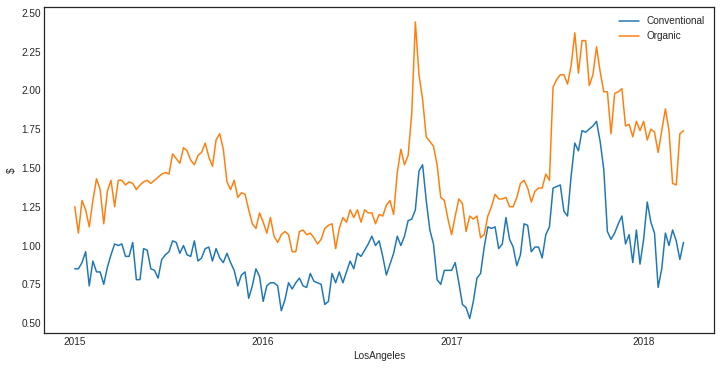

LosAngeles average price conventional:  0.98
LosAngeles average price organic:  1.45


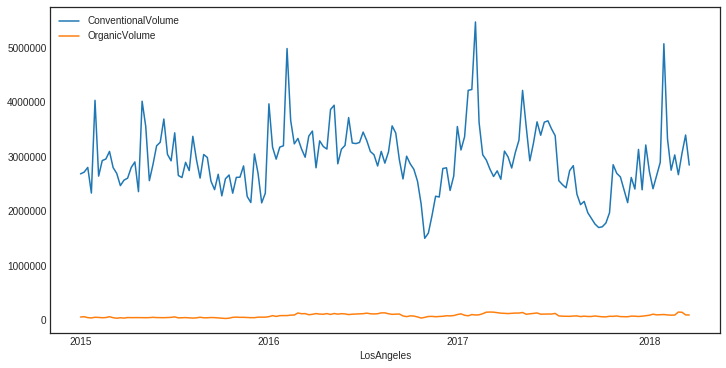

LosAngeles total volume conventional:  482545330
LosAngeles total volume organic:  12913428


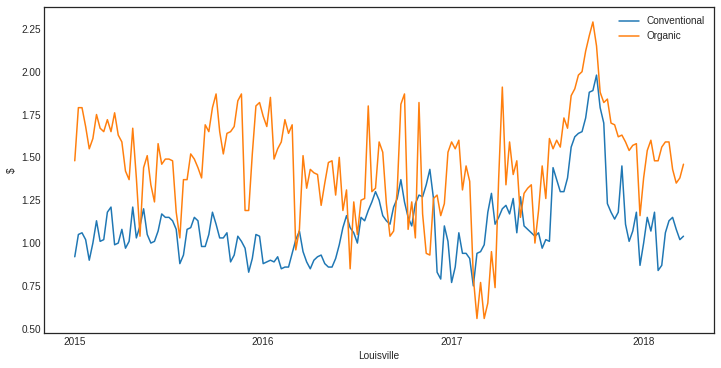

Louisville average price conventional:  1.11
Louisville average price organic:  1.47


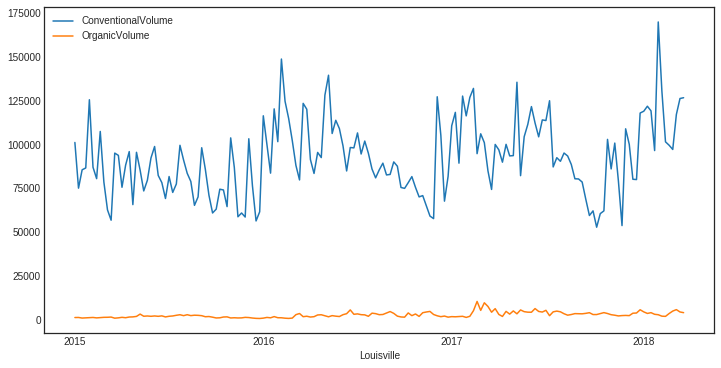

Louisville total volume conventional:  15137667
Louisville total volume organic:  472447


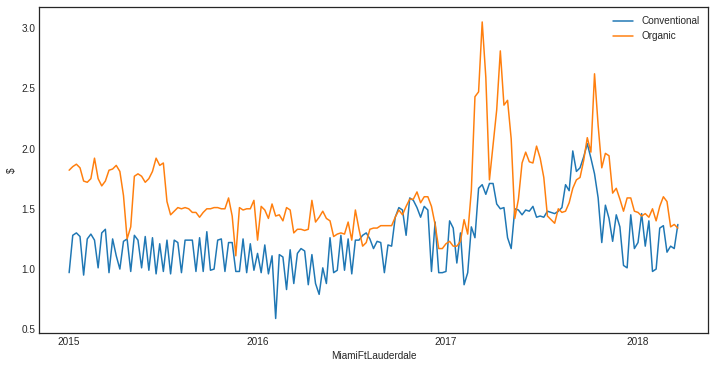

MiamiFtLauderdale average price conventional:  1.26
MiamiFtLauderdale average price organic:  1.61


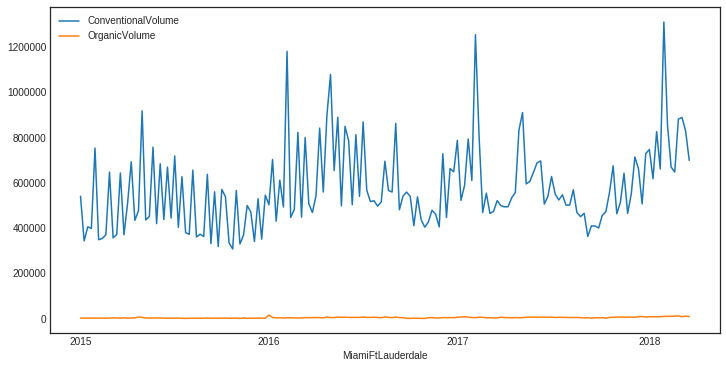

MiamiFtLauderdale total volume conventional:  93713096
MiamiFtLauderdale total volume organic:  623747


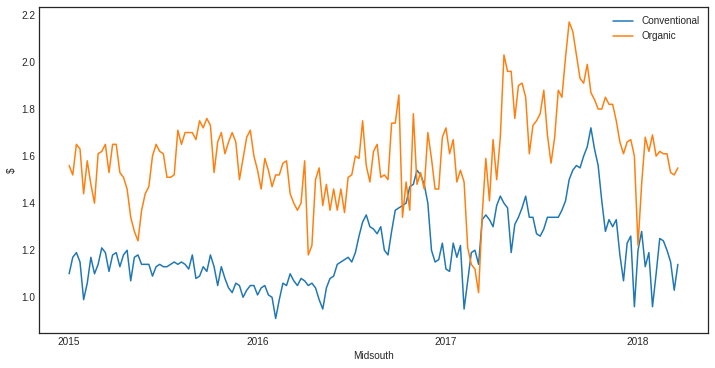

Midsouth average price conventional:  1.21
Midsouth average price organic:  1.6


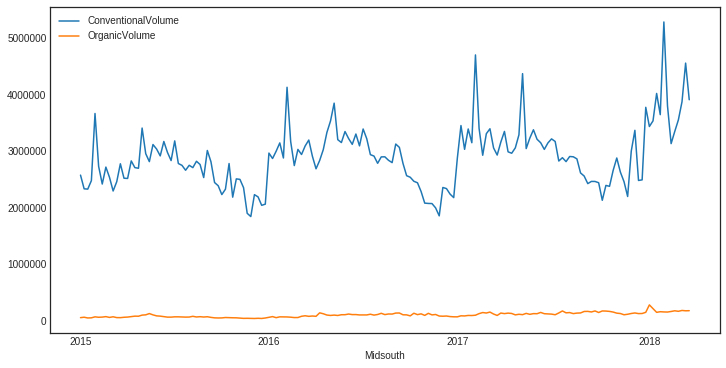

Midsouth total volume conventional:  474470557
Midsouth total volume organic:  17264692


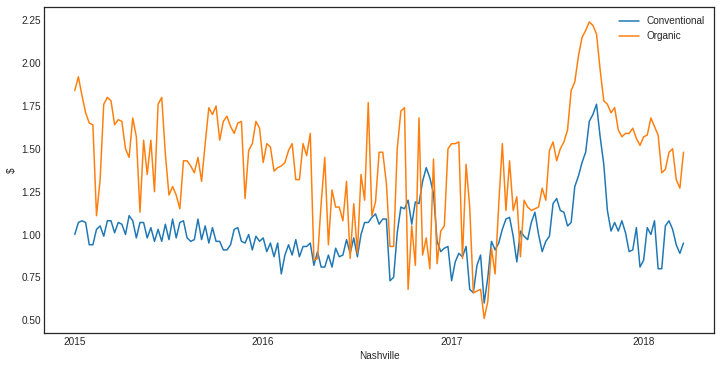

Nashville average price conventional:  1.01
Nashville average price organic:  1.41


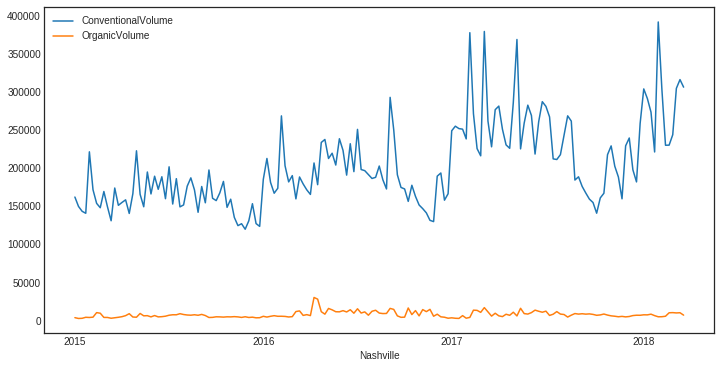

Nashville total volume conventional:  33072341
Nashville total volume organic:  1330297


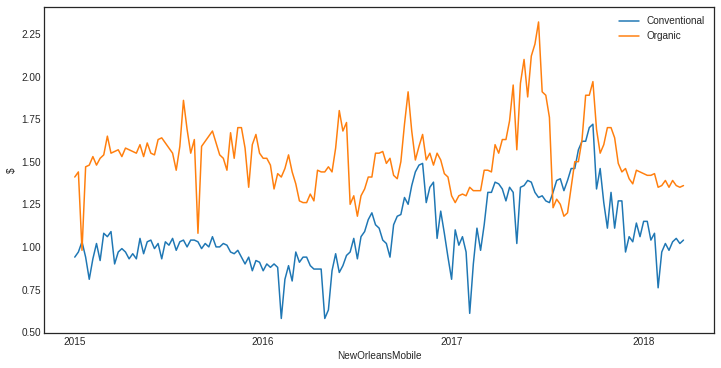

NewOrleansMobile average price conventional:  1.09
NewOrleansMobile average price organic:  1.53


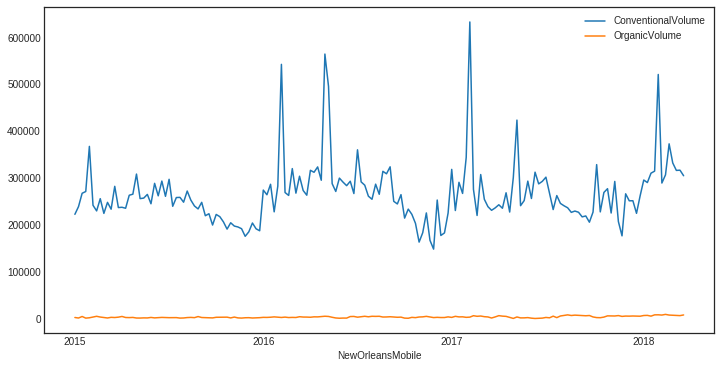

NewOrleansMobile total volume conventional:  43796574
NewOrleansMobile total volume organic:  598382


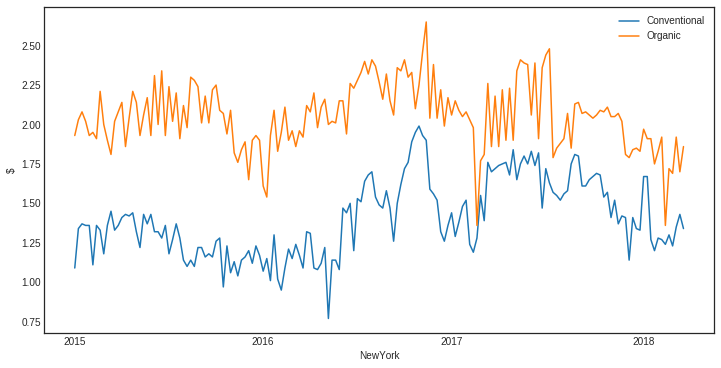

NewYork average price conventional:  1.4
NewYork average price organic:  2.06


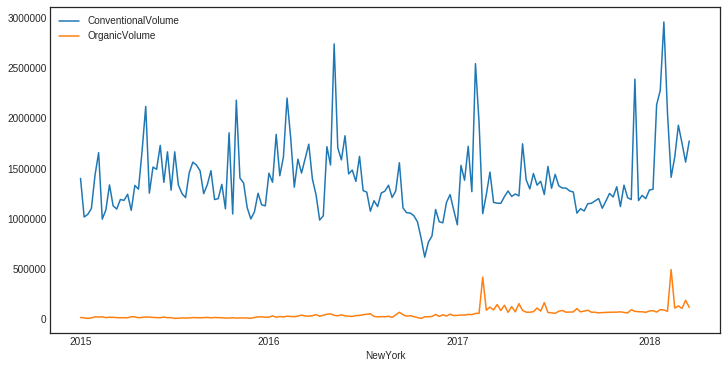

NewYork total volume conventional:  224717371
NewYork total volume organic:  8440751


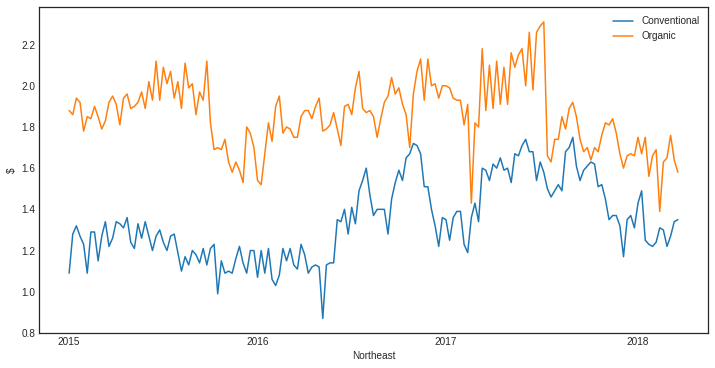

Northeast average price conventional:  1.35
Northeast average price organic:  1.86


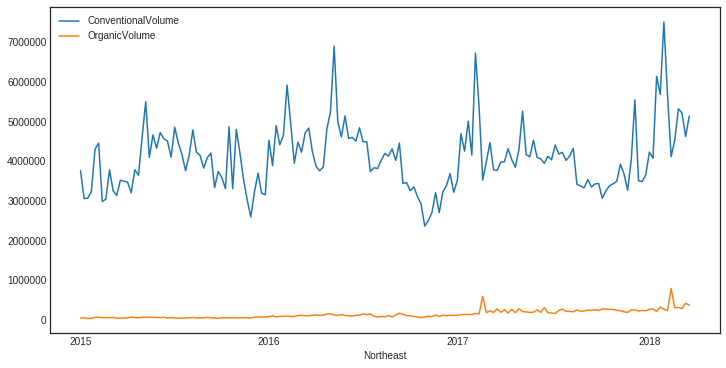

Northeast total volume conventional:  668766358
Northeast total volume organic:  22830419


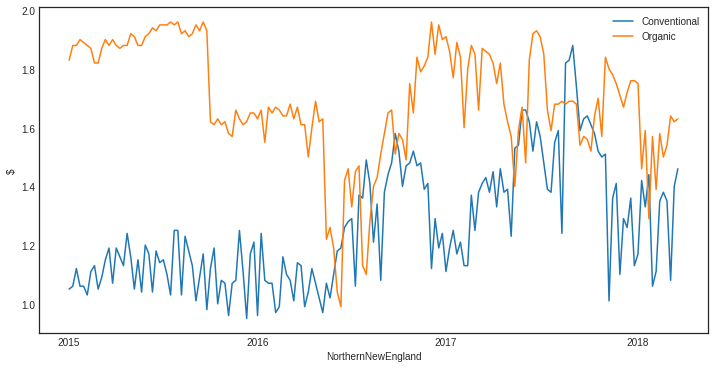

NorthernNewEngland average price conventional:  1.26
NorthernNewEngland average price organic:  1.7


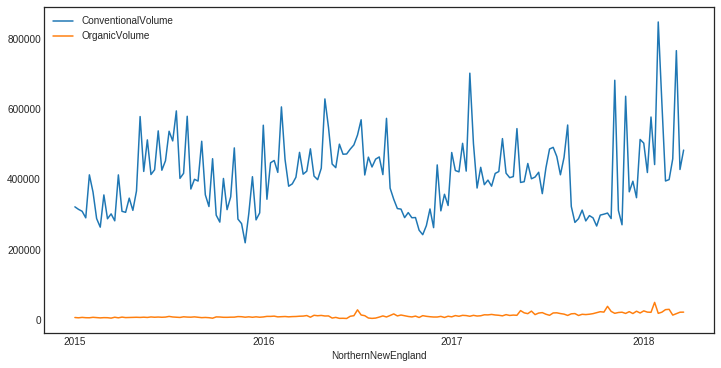

NorthernNewEngland total volume conventional:  67205763
NorthernNewEngland total volume organic:  2114699


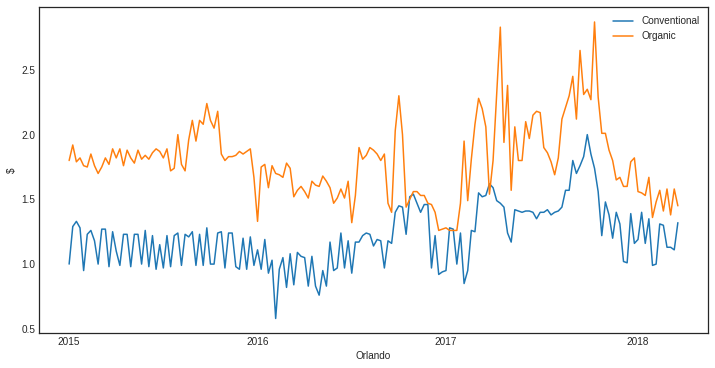

Orlando average price conventional:  1.22
Orlando average price organic:  1.81


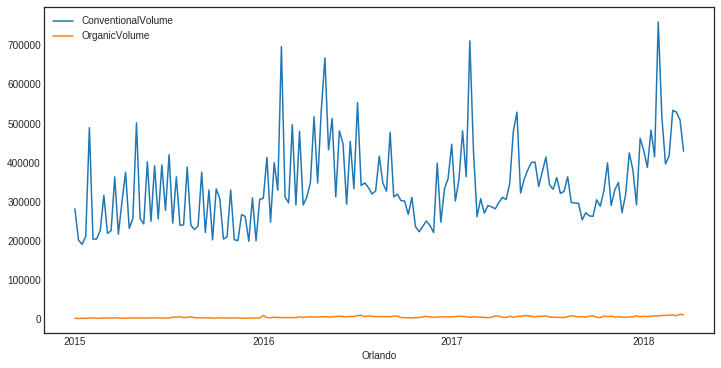

Orlando total volume conventional:  55775038
Orlando total volume organic:  842164


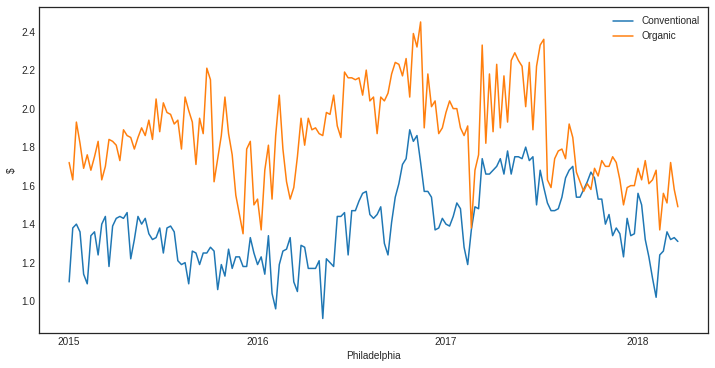

Philadelphia average price conventional:  1.4
Philadelphia average price organic:  1.88


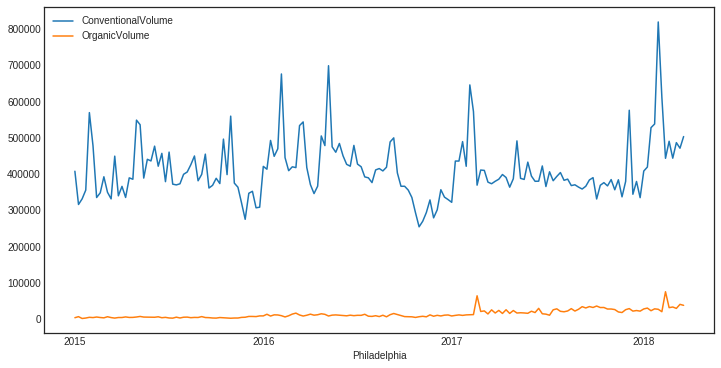

Philadelphia total volume conventional:  67575097
Philadelphia total volume organic:  2217735


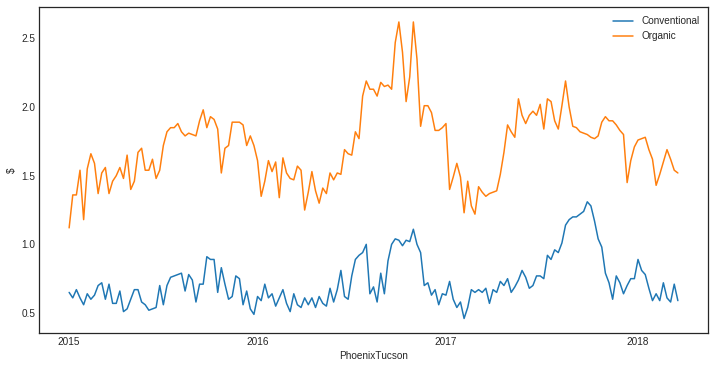

PhoenixTucson average price conventional:  0.73
PhoenixTucson average price organic:  1.72


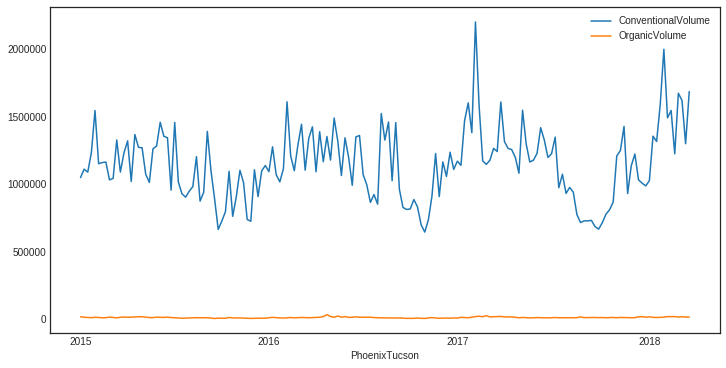

PhoenixTucson total volume conventional:  187323623
PhoenixTucson total volume organic:  1979423


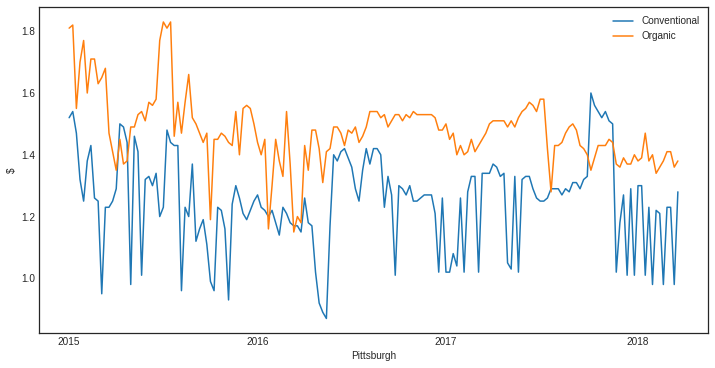

Pittsburgh average price conventional:  1.25
Pittsburgh average price organic:  1.48


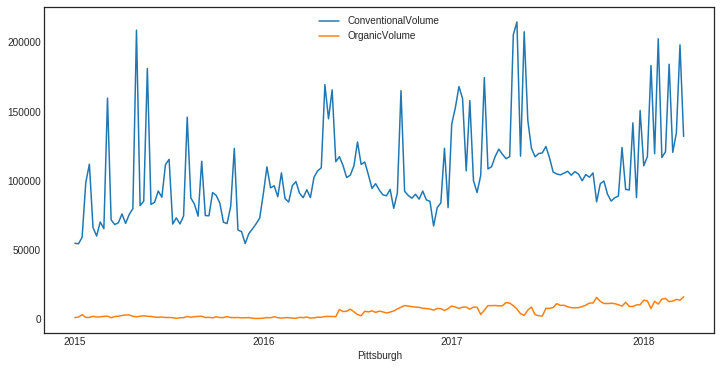

Pittsburgh total volume conventional:  17246322
Pittsburgh total volume organic:  916466


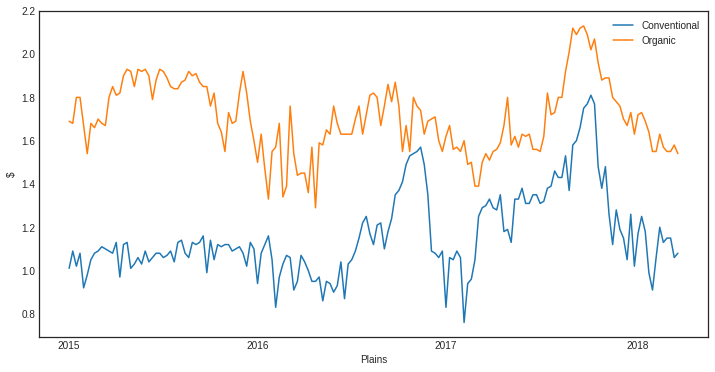

Plains average price conventional:  1.17
Plains average price organic:  1.71


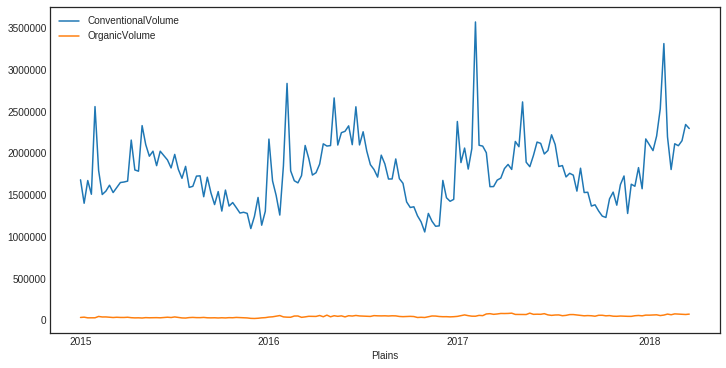

Plains total volume conventional:  294023050
Plains total volume organic:  7985121


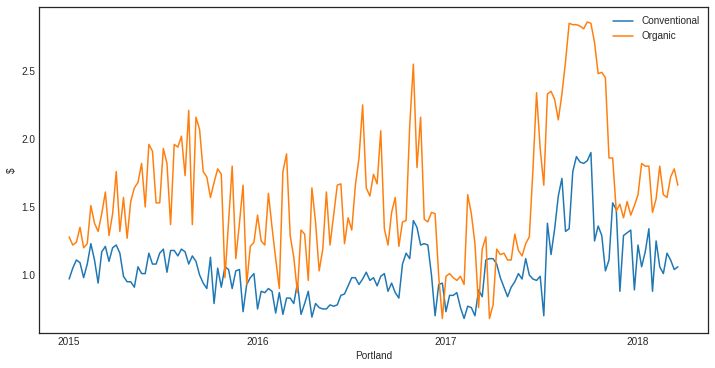

Portland average price conventional:  1.05
Portland average price organic:  1.59


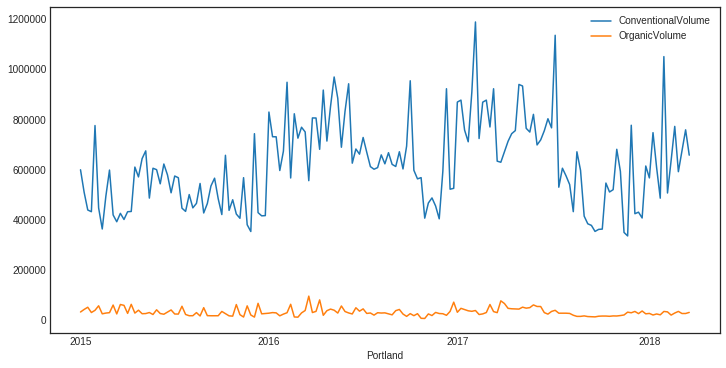

Portland total volume conventional:  102355281
Portland total volume organic:  5390549


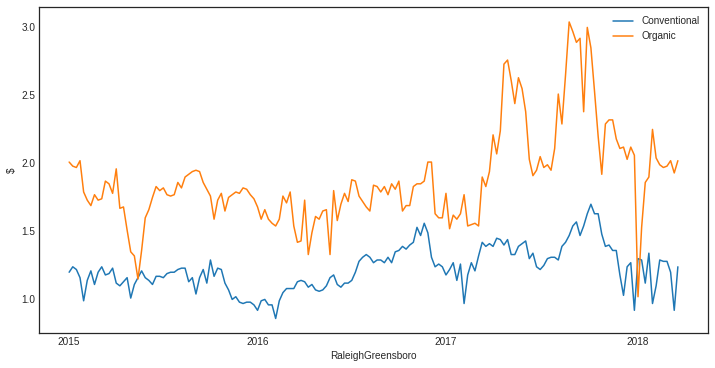

RaleighGreensboro average price conventional:  1.23
RaleighGreensboro average price organic:  1.88


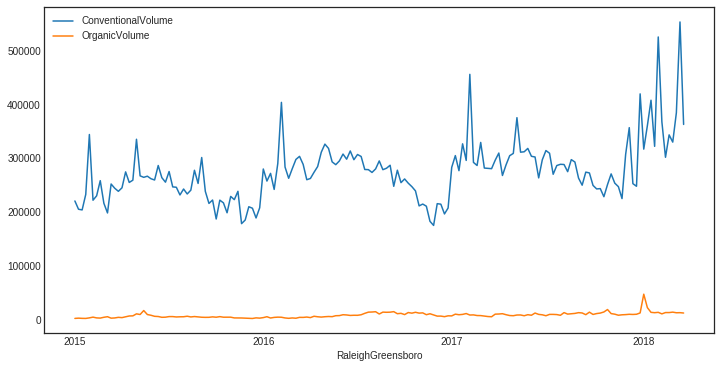

RaleighGreensboro total volume conventional:  44987718
RaleighGreensboro total volume organic:  1528070


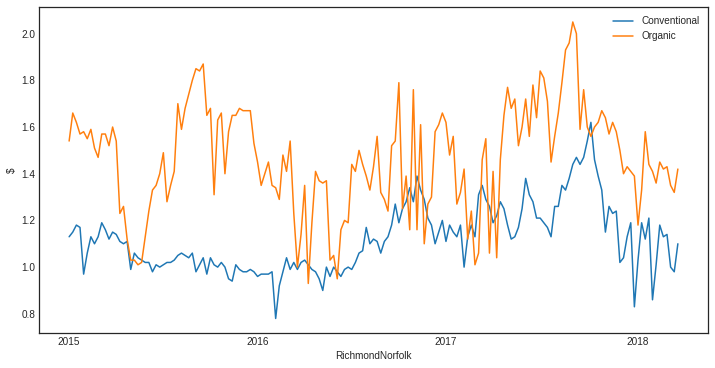

RichmondNorfolk average price conventional:  1.12
RichmondNorfolk average price organic:  1.46


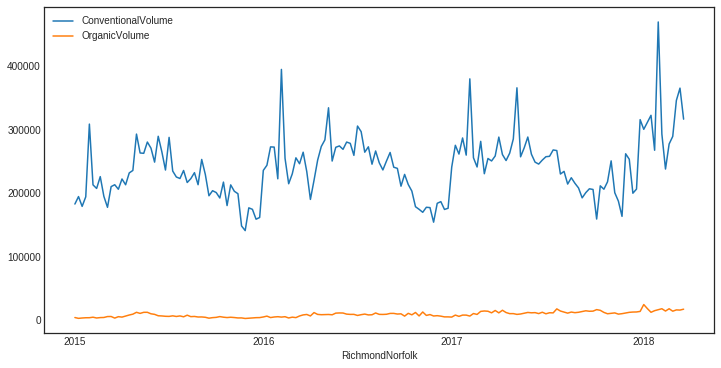

RichmondNorfolk total volume conventional:  39369023
RichmondNorfolk total volume organic:  1482140


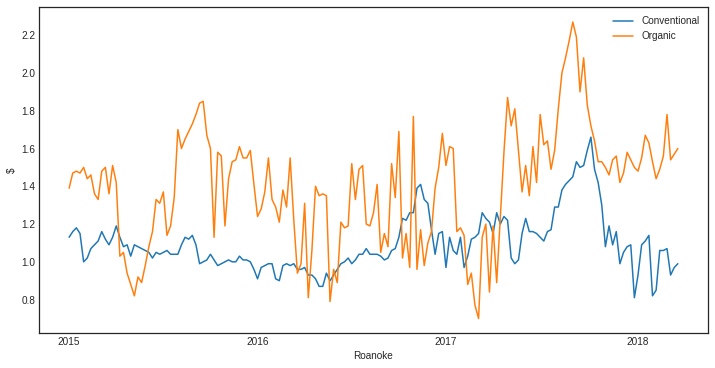

Roanoke average price conventional:  1.1
Roanoke average price organic:  1.39


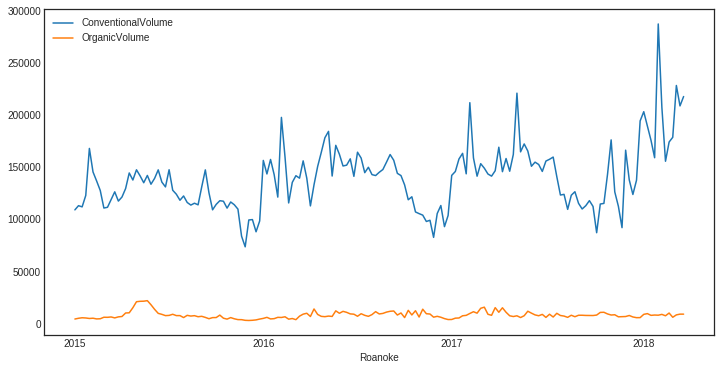

Roanoke total volume conventional:  22818090
Roanoke total volume organic:  1356581


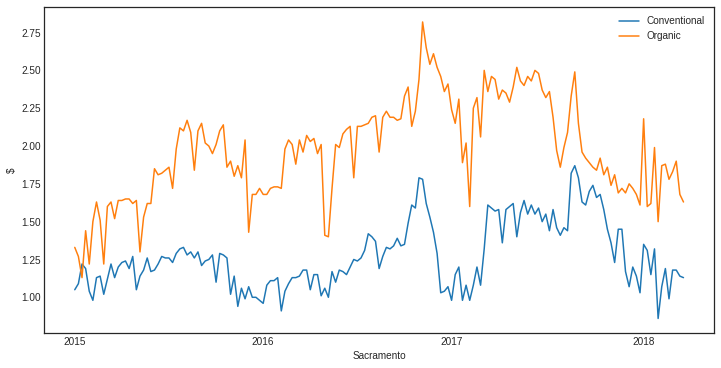

Sacramento average price conventional:  1.28
Sacramento average price organic:  1.97


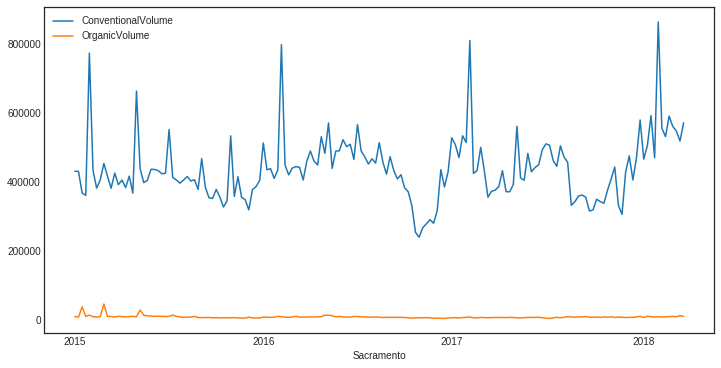

Sacramento total volume conventional:  71618373
Sacramento total volume organic:  1311399


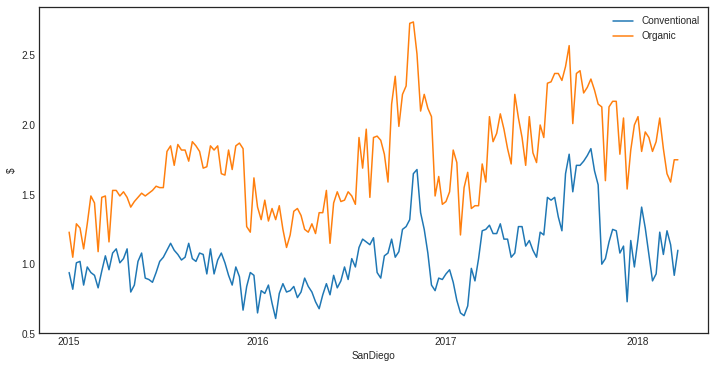

SanDiego average price conventional:  1.06
SanDiego average price organic:  1.74


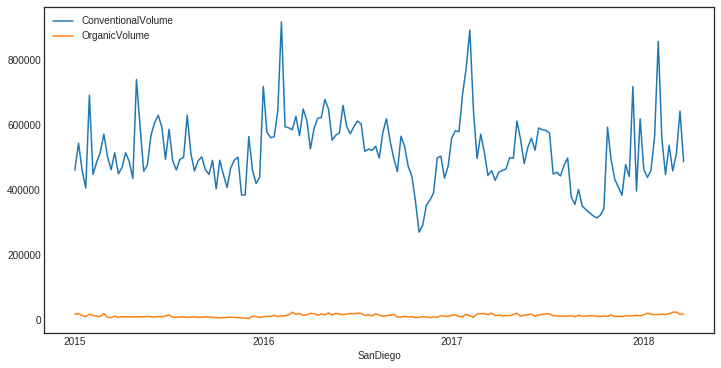

SanDiego total volume conventional:  85292968
SanDiego total volume organic:  2308461


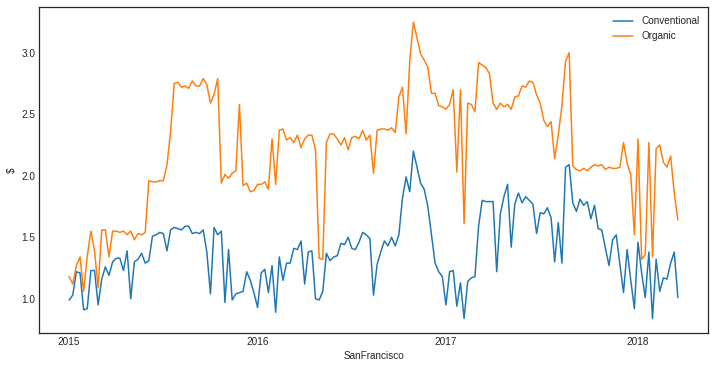

SanFrancisco average price conventional:  1.4
SanFrancisco average price organic:  2.22


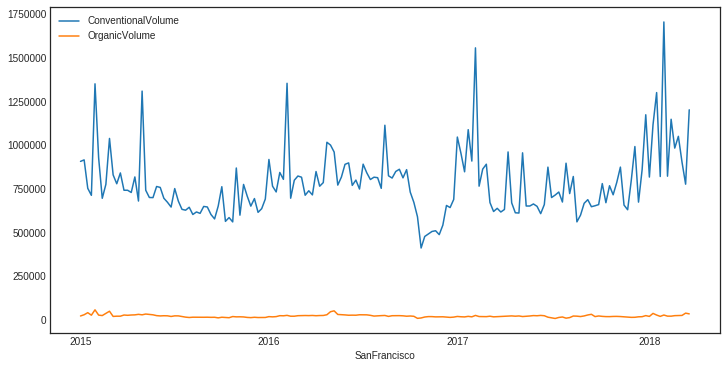

SanFrancisco total volume conventional:  128108038
SanFrancisco total volume organic:  3661605


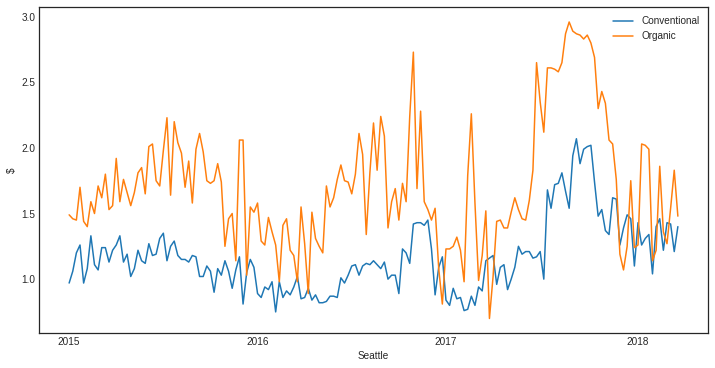

Seattle average price conventional:  1.17
Seattle average price organic:  1.72


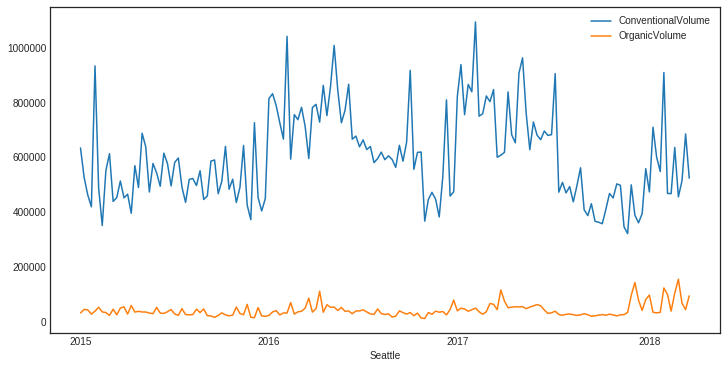

Seattle total volume conventional:  99669829
Seattle total volume organic:  6996031


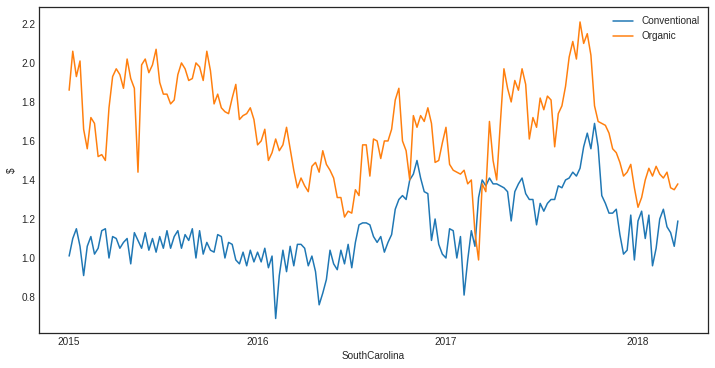

SouthCarolina average price conventional:  1.15
SouthCarolina average price organic:  1.67


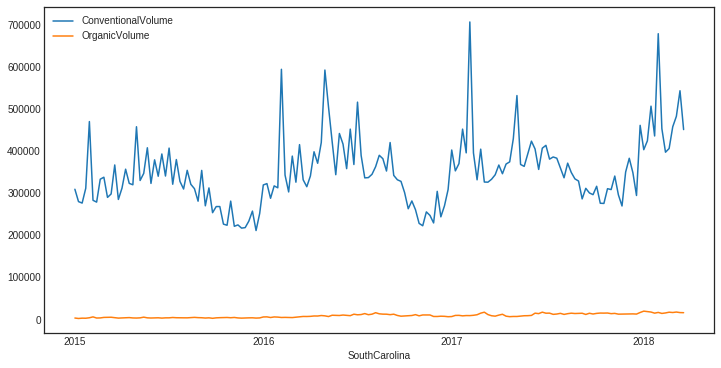

SouthCarolina total volume conventional:  57315510
SouthCarolina total volume organic:  1438941


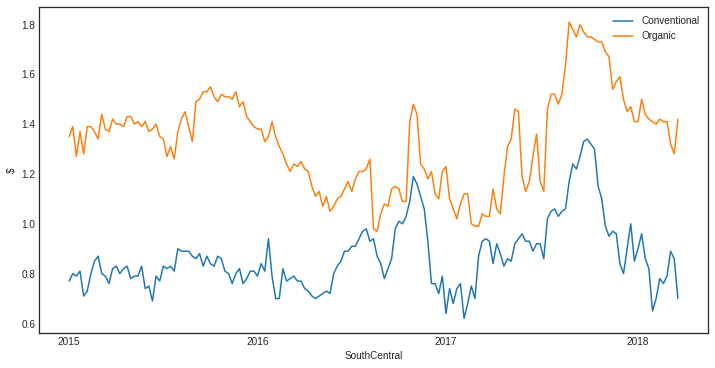

SouthCentral average price conventional:  0.87
SouthCentral average price organic:  1.33


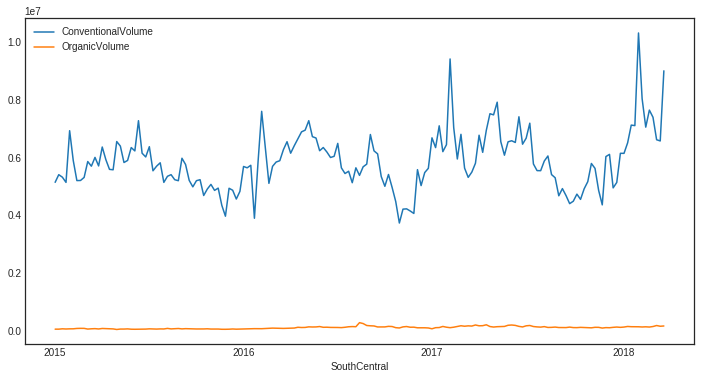

SouthCentral total volume conventional:  963550412
SouthCentral total volume organic:  17477034


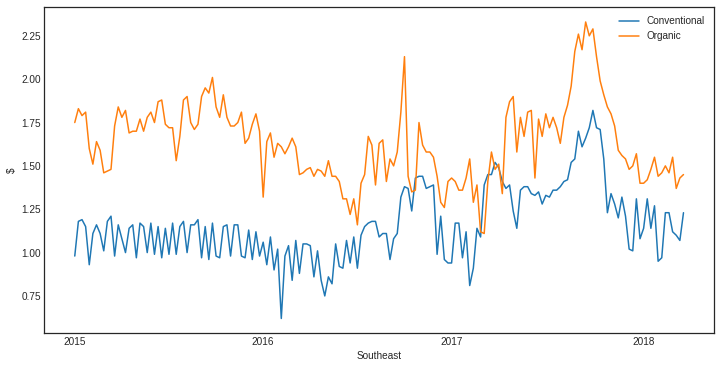

Southeast average price conventional:  1.16
Southeast average price organic:  1.64


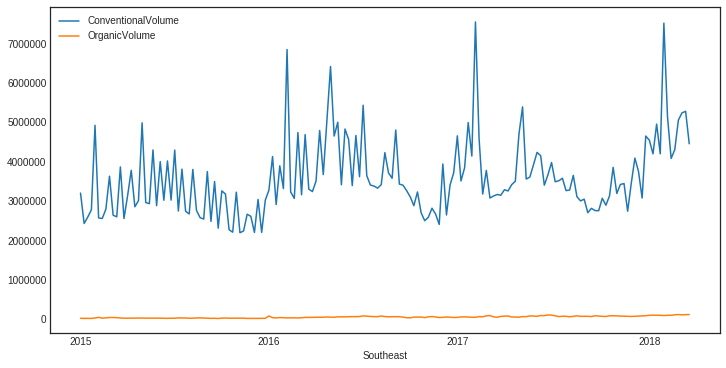

Southeast total volume conventional:  585171041
Southeast total volume organic:  9561624


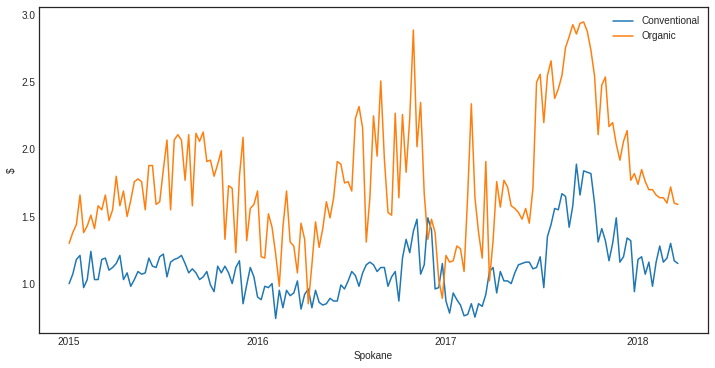

Spokane average price conventional:  1.11
Spokane average price organic:  1.78


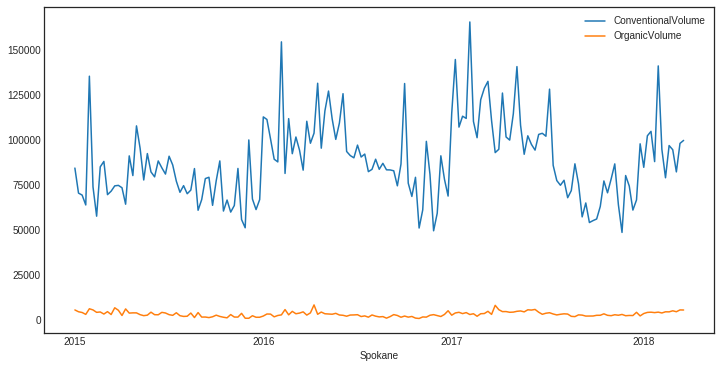

Spokane total volume conventional:  14601226
Spokane total volume organic:  566806


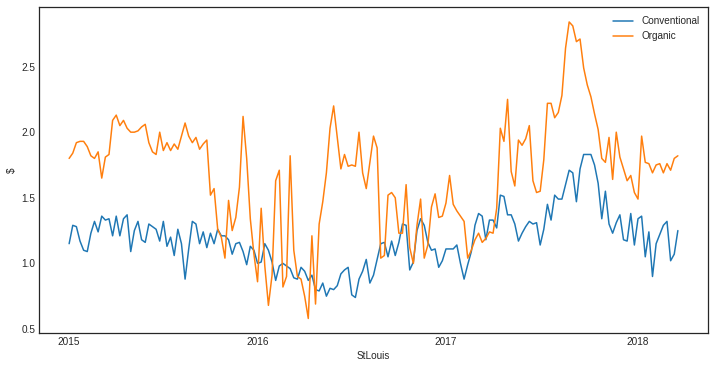

StLouis average price conventional:  1.19
StLouis average price organic:  1.67


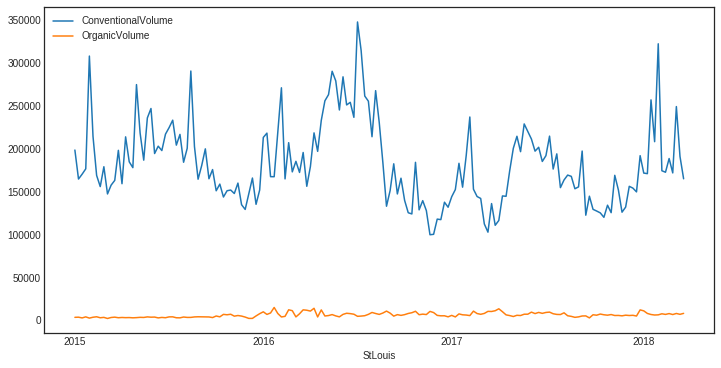

StLouis total volume conventional:  30216410
StLouis total volume organic:  1048190


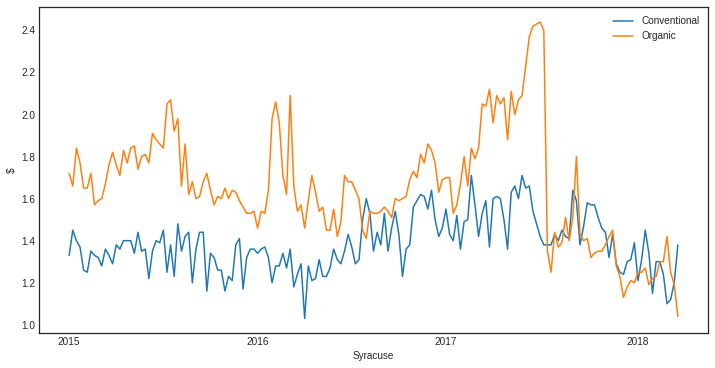

Syracuse average price conventional:  1.39
Syracuse average price organic:  1.66


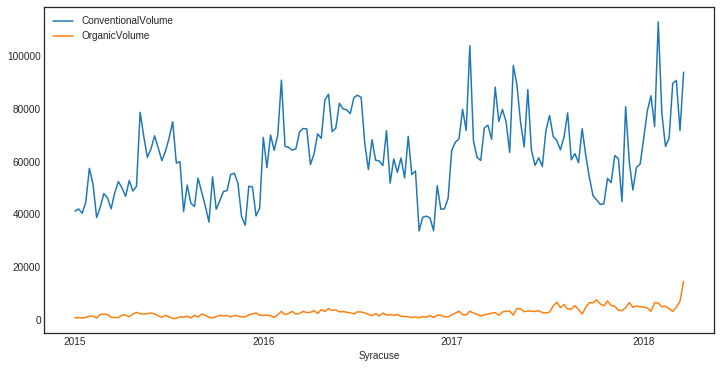

Syracuse total volume conventional:  10145774
Syracuse total volume organic:  421443


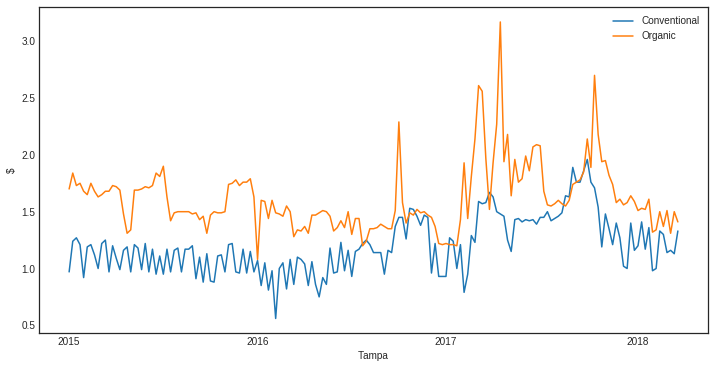

Tampa average price conventional:  1.2
Tampa average price organic:  1.62


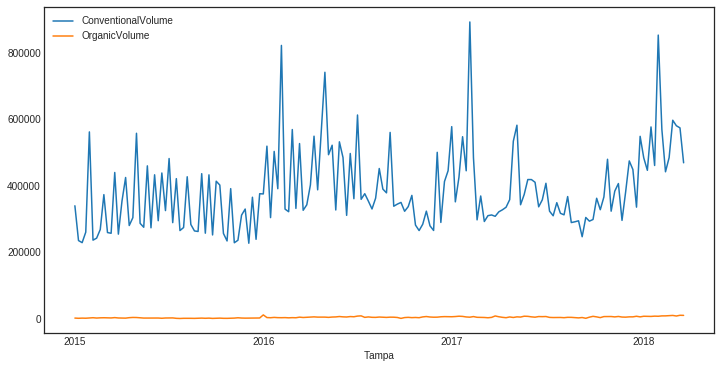

Tampa total volume conventional:  63066467
Tampa total volume organic:  677960


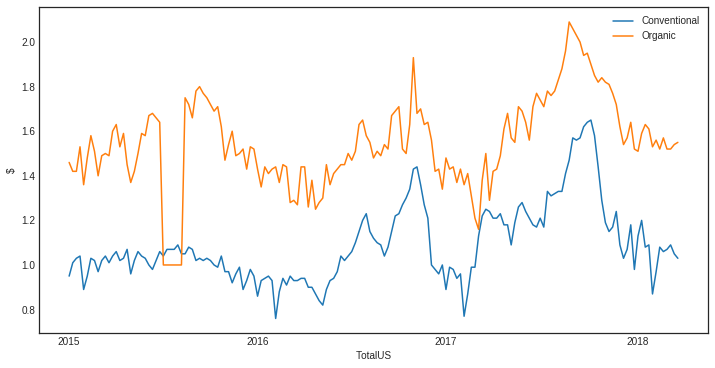

TotalUS average price conventional:  1.09
TotalUS average price organic:  1.55


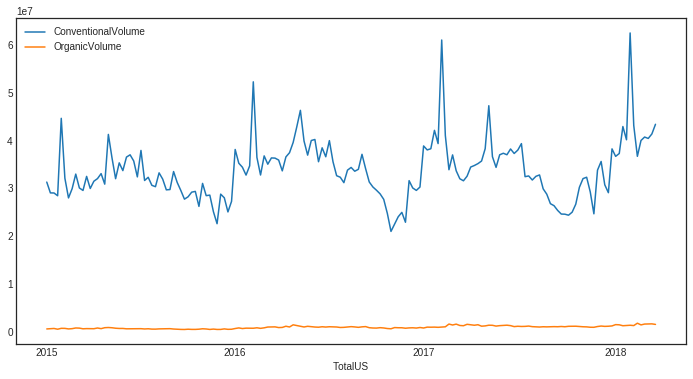

TotalUS total volume conventional:  5535234619
TotalUS total volume organic:  156984158


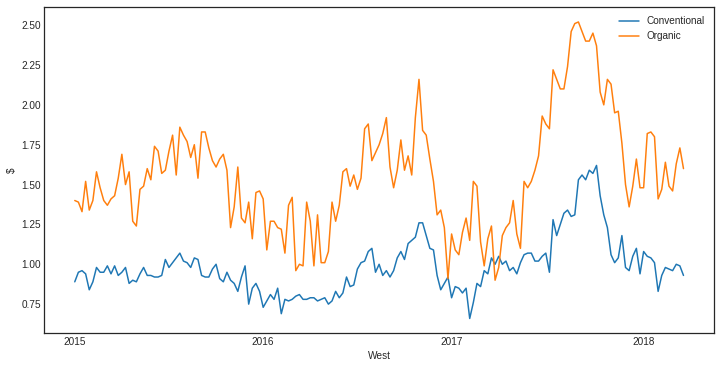

West average price conventional:  0.99
West average price organic:  1.56


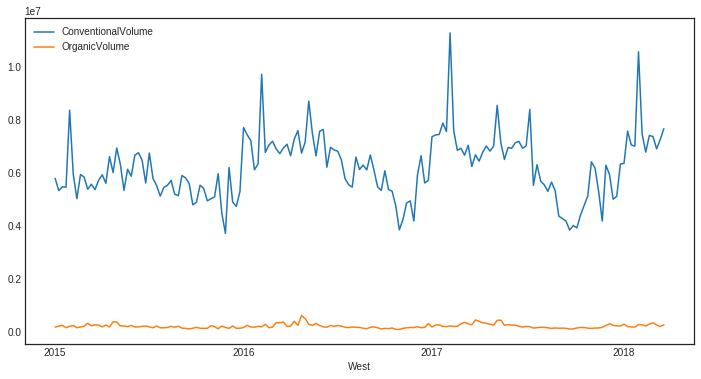

West total volume conventional:  1020160673
West total volume organic:  36324710


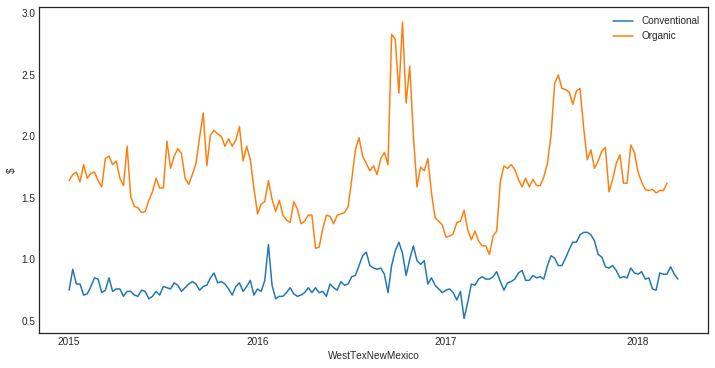

WestTexNewMexico average price conventional:  0.84
WestTexNewMexico average price organic:  1.69


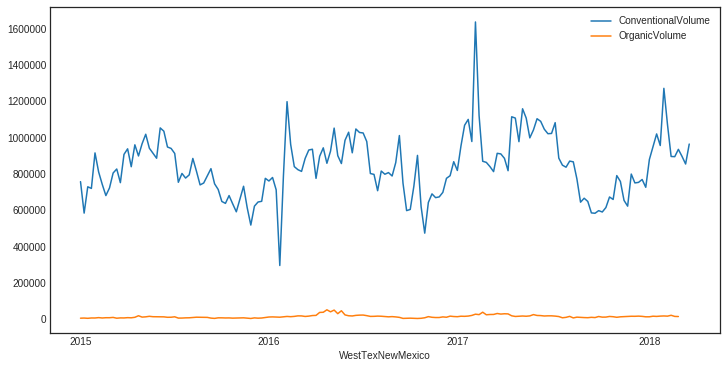

WestTexNewMexico total volume conventional:  138332757
WestTexNewMexico total volume organic:  2519800


In [9]:
#Plot prices and volumes for every region
for city in cities:
    pricesForCity(city)
    volumesForCity(city)

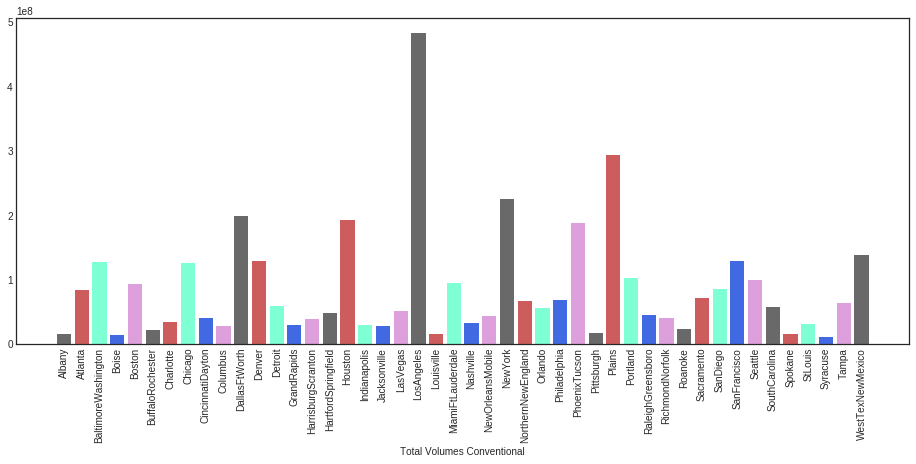

Text(0.5, 0, 'Total Volumes Organic')

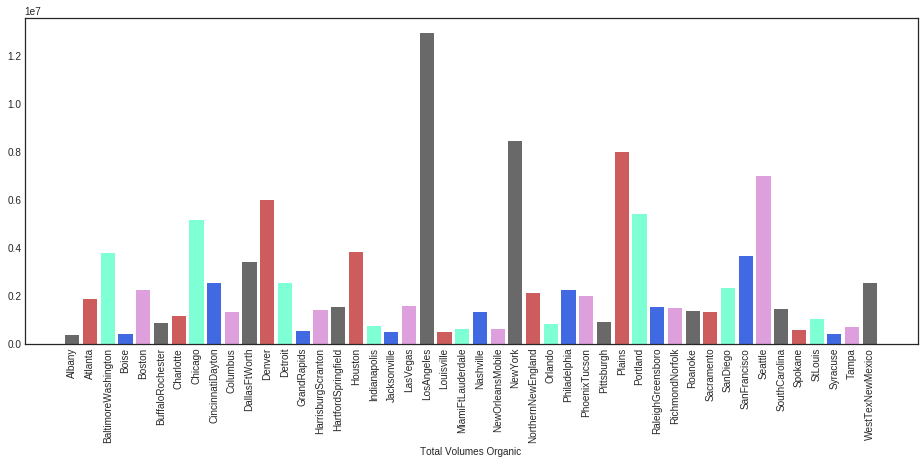

In [10]:
#Plot Total Volumes of all time for every city (states and combined areas are left out)

cities = []
volumes = []
for i in range(len(totalVolumesAndCitiesConvent)):
    if totalVolumesAndCitiesConvent[i][0] != "TotalUS" and totalVolumesAndCitiesConvent[i][0] != "West" and totalVolumesAndCitiesConvent[i][0] != "SouthCentral" and totalVolumesAndCitiesConvent[i][0] != "Southeast" and totalVolumesAndCitiesConvent[i][0] != "Midsouth" and totalVolumesAndCitiesConvent[i][0] != "California" and totalVolumesAndCitiesOrgan[i][0] != "Northeast" and totalVolumesAndCitiesOrgan[i][0] != "GreatLakes":
        cities.append(totalVolumesAndCitiesConvent[i][0])
        volumes.append(int(totalVolumesAndCitiesConvent[i][1]))

plt_1 = plt.figure(figsize=(16,6))
plt.bar(cities, volumes, color=['dimgray', 'Indianred', 'aquamarine', 'royalblue', 'plum'])
plt.xticks(rotation='vertical')
plt.xlabel("Total Volumes Conventional")
plt.show()

cities = []
volumes = []
for i in range(len(totalVolumesAndCitiesOrgan)):
    if totalVolumesAndCitiesOrgan[i][0] != "TotalUS" and totalVolumesAndCitiesOrgan[i][0] != "West" and totalVolumesAndCitiesOrgan[i][0] != "SouthCentral" and totalVolumesAndCitiesOrgan[i][0] != "Southeast" and totalVolumesAndCitiesOrgan[i][0] != "Midsouth" and totalVolumesAndCitiesOrgan[i][0] != "California" and totalVolumesAndCitiesOrgan[i][0] != "Northeast" and totalVolumesAndCitiesOrgan[i][0] != "GreatLakes":
        cities.append(totalVolumesAndCitiesOrgan[i][0])
        volumes.append(int(totalVolumesAndCitiesOrgan[i][1]))

plt_1 = plt.figure(figsize=(16,6))
plt.bar(cities, volumes, color=['dimgray', 'Indianred', 'aquamarine', 'royalblue', 'plum'])
plt.xticks(rotation='vertical')
plt.xlabel("Total Volumes Organic")

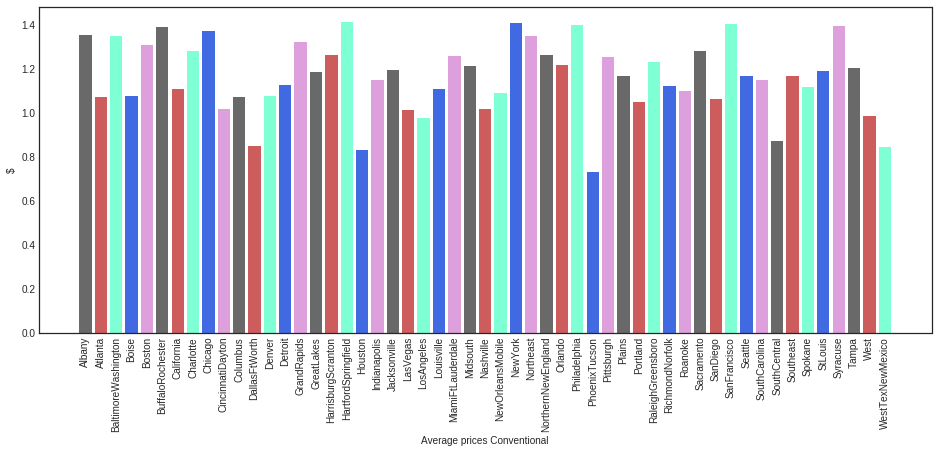

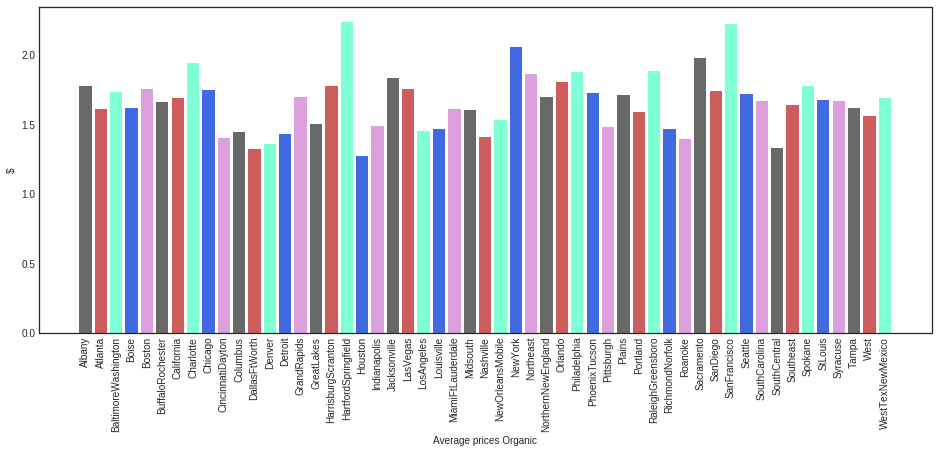

In [11]:
#Plot Average Prices of all time

cities = []
prices = []
for i in range(len(averagePricesAndCitiesConvent)):
    if not averagePricesAndCitiesConvent[i][0] == "TotalUS":
        cities.append(averagePricesAndCitiesConvent[i][0])
        prices.append(averagePricesAndCitiesConvent[i][1])

plt_1 = plt.figure(figsize=(16,6))
plt.bar(cities, prices, color=['dimgray', 'Indianred', 'aquamarine', 'royalblue', 'plum'])
plt.xticks(rotation='vertical')
plt.xlabel("Average prices Conventional")
plt.ylabel("$")
plt.show()

#Find out max and min prices
maximum = max(prices)
for j in range(len(prices)):
    if prices[j] == maximum:
        maxConvent = cities[j]
        
minimum = min(prices)
for j in range(len(prices)):
    if prices[j] == minimum:
        minConvent = cities[j]

cities = []
prices = []
for i in range(len(averagePricesAndCitiesConvent)):
    if not averagePricesAndCitiesOrgan[i][0] == "TotalUS":
        cities.append(averagePricesAndCitiesOrgan[i][0])
        prices.append(averagePricesAndCitiesOrgan[i][1])

plt_1 = plt.figure(figsize=(16,6))
plt.bar(cities, prices, color=['dimgray', 'Indianred', 'aquamarine', 'royalblue', 'plum'])
plt.xticks(rotation='vertical')
plt.xlabel("Average prices Organic")
plt.ylabel("$")
plt.show()

#Find out max and min prices for organic
maximum = max(prices)
for j in range(len(prices)):
    if prices[j] == maximum:
        maxOrganic = cities[j]
        
minimum = min(prices)
for j in range(len(prices)):
    if prices[j] == minimum:
        minOrganic = cities[j]

The most expensive


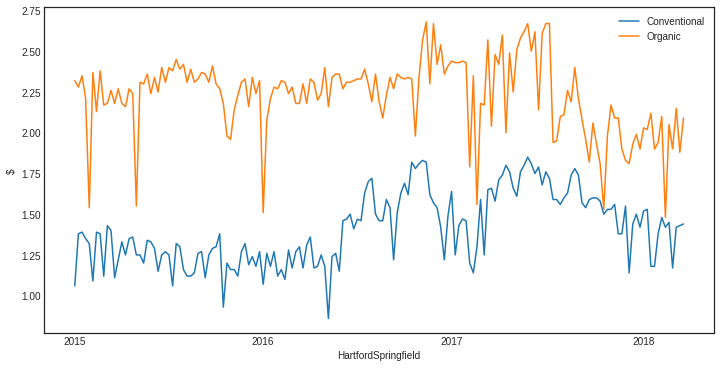

HartfordSpringfield average price conventional:  1.41
HartfordSpringfield average price organic:  2.23

The cheapest Conventional


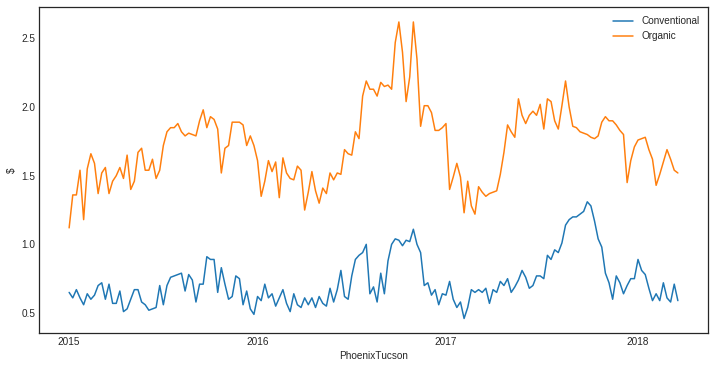

PhoenixTucson average price conventional:  0.73
PhoenixTucson average price organic:  1.72

The cheapest Organic


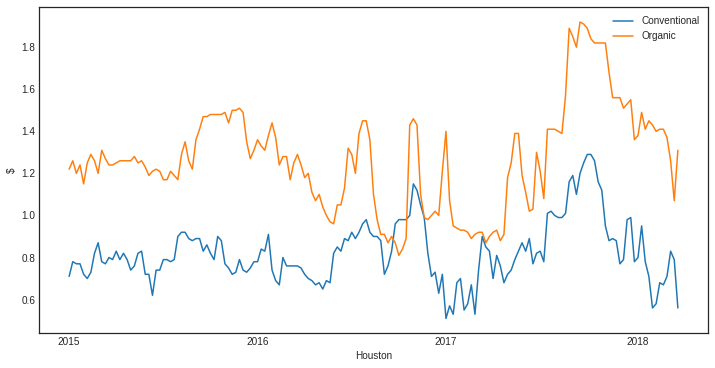

Houston average price conventional:  0.83
Houston average price organic:  1.27


In [12]:
#Plot mins and maxes
if maxConvent == maxOrganic:
    print("The most expensive")
    pricesForCity(maxConvent)
else:
    print("\nThe most expensive Conventional")
    pricesForCity(maxConvent)
    print("\nThe most expensive Organic")
    pricesForCity(maxOrganic)
    
if minConvent == minOrganic:
    print("\nThe cheapest")
    pricesForCity(minConvent)
else:
    print("\nThe cheapest Conventional")
    pricesForCity(minConvent)
    print("\nThe cheapest Organic")
    pricesForCity(minOrganic)

In [13]:
def compareCityPrices(city1, city2, avocado):
    dataCity1 = data.filter(data.region == city1).filter(data.type == avocado).orderBy("Date")
    dataCity2 = data.filter(data.region == city2).filter(data.type == avocado).orderBy("Date")
    
    dataPricesCity1 = dataCity1.select("AveragePrice", "year")
    dataPricesCity2 = dataCity2.select("AveragePrice", "year")

    dff1 = dataPricesCity1.toPandas()
    dff2 = dataPricesCity2.toPandas()
    
    #Plot for average price
    plt.style.use('seaborn-white')
    plt_1 = plt.figure(figsize=(12,6))
    params = {'legend.fontsize': 'large','figure.figsize': (80, 40),'axes.labelsize': 'x-large','axes.titlesize':'x-large','xtick.labelsize':'large','ytick.labelsize':'large'}
    
    plt.plot(dff1.AveragePrice)
    plt.plot(dff2.AveragePrice)
    plt.xticks(range(len(yearsForX)), yearsForX)
    plt.xlabel(avocado)
    plt.ylabel("$")
    plt.legend([city1, city2])
    plt.show()
    plt.close()
    
    priceAver1 = 0
    priceAver2= 0
    for i in range(165):
        priceAver1 = priceAver1 + dff1.AveragePrice[i]
        priceAver2 = priceAver2 + dff2.AveragePrice[i]
    
    print(city1, "average price", str(round(priceAver1/165, 2)))
    print(city2, "average price", str(round(priceAver2/165, 2)))

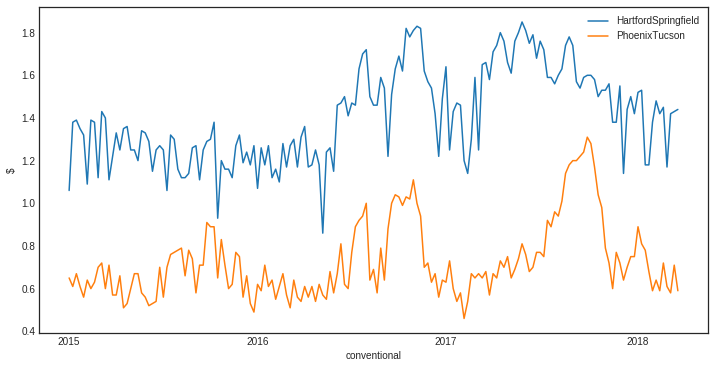

HartfordSpringfield average price 1.41
PhoenixTucson average price 0.73


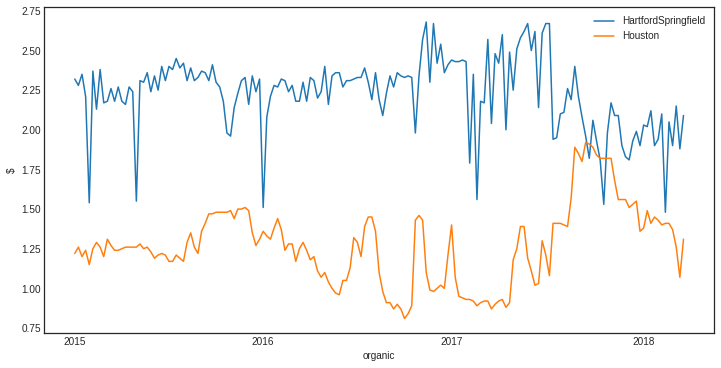

HartfordSpringfield average price 2.23
Houston average price 1.27


In [14]:
#Compare 
compareCityPrices("HartfordSpringfield", "PhoenixTucson", "conventional")
compareCityPrices("HartfordSpringfield", "Houston", "organic")

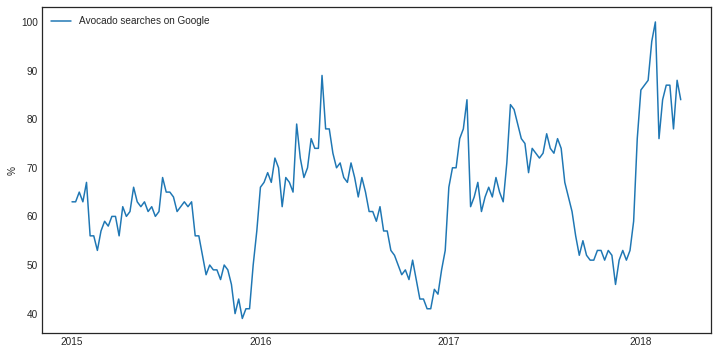

In [15]:
#Plot the results of Google Trend for the term 'avocado'
avocadoTrends = trendsData.select("avocado")
dff = avocadoTrends.toPandas()
plt.style.use('seaborn-white')
plt_1 = plt.figure(figsize=(12,6))
params = {'legend.fontsize': 'large','figure.figsize': (80, 40),'axes.labelsize': 'x-large','axes.titlesize':'x-large','xtick.labelsize':'large','ytick.labelsize':'large'}
plt.plot(dff)
plt.legend(["Avocado searches on Google"])
plt.ylabel("%")
plt.xticks(range(len(yearsForX)), yearsForX)
plt.show()

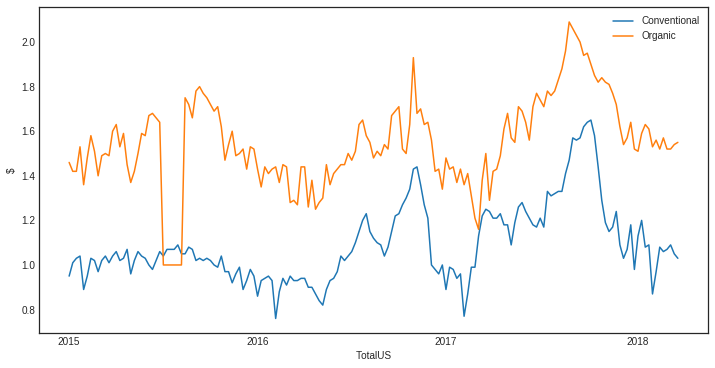

TotalUS average price conventional:  1.09
TotalUS average price organic:  1.55


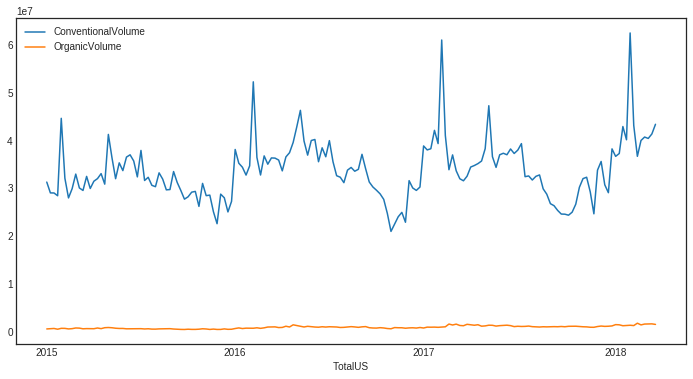

TotalUS total volume conventional:  5535234619
TotalUS total volume organic:  156984158


In [16]:
#Plot prices and volumes for the whole US
pricesForCity('TotalUS')
volumesForCity('TotalUS')

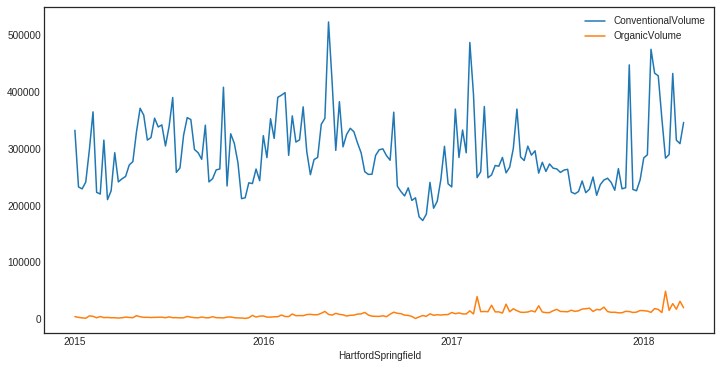

HartfordSpringfield total volume conventional:  47659601
HartfordSpringfield total volume organic:  1512003


In [17]:
volumesForCity("HartfordSpringfield")